# Problem Statement
Forecast the CocaCola prices.
Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model.Finally which model you will use for Forecasting.

# About the DataSet:
    
This data is consist the Quarterly Sales data of leading Refreshment drink"Coca-Cola" from year 1986 to 1996.This dataset is having 42 rows & two columns(Quarter & Sales).

As per the problem statement need to prepare the model which have the lowest RMSE values in comparision with others. Will have to do the necessary EDA, data preprocessing methods & some forecasting techniques/ methods like Seasonality, exponentional(Holt winter method), ARIMA etc.& in order to evaluate will check the RMSE & MAPE scores of each models.

In [286]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from decimal import Decimal
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

In [287]:
cc=pd.read_excel('C:/Users/VivekG/Desktop/My Files- Vivek/ExcelrThane/DS/Assignments/Forecasting/CocaCola_Sales_Rawdata.xlsx')

In [288]:
cc.head()

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996

In [289]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [290]:
cc.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [291]:
cc.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [292]:
cc.shape

(42, 2)

In [293]:
cc.dtypes

Quarter     object
Sales      float64
dtype: object

In [294]:
cc.nunique()

Quarter    42
Sales      42
dtype: int64

In [295]:
cc[cc.duplicated()].shape

(0, 2)

In [296]:
cc[cc.duplicated()]

Empty DataFrame
Columns: [Quarter, Sales]
Index: []

In [297]:
cc.describe()

Sales
count    42.000000
mean   2994.353308
std     977.930896
min    1547.818996
25%    2159.714247
50%    2782.376999
75%    3609.250000
max    5253.000000

# Feature Engineering

In [298]:
#Converting the Quarters into Years

In [299]:
cc['Quarter_Year'] = cc['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
cc.head(10)


Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987
5   Q2_87  2104.411995      Q2 1987
6   Q3_87  2014.362999      Q3 1987
7   Q4_87  1991.746998      Q4 1987
8   Q1_88  1869.049999      Q1 1988
9   Q2_88  2313.631996      Q2 1988

In [300]:
# Converting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [301]:
# converting into datetime formate as the index was not in correct formate.
cc['Date'] = (
    pd.to_datetime(
        cc['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
cc.head(10)


Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01
5   Q2_87  2104.411995      Q2 1987 1987-04-01
6   Q3_87  2014.362999      Q3 1987 1987-07-01
7   Q4_87  1991.746998      Q4 1987 1987-10-01
8   Q1_88  1869.049999      Q1 1988 1988-01-01
9   Q2_88  2313.631996      Q2 1988 1988-04-01

In [302]:
# Extracting the Quarters and putting in column

In [303]:
cc['Quarters'] = 0

for i in range(42):
    n = cc['Quarter'][i]
    cc['Quarters'][i] = n[0:2]
    
cc.head(10)



Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2

In [304]:
#Creating Dummy Variables for Quarters.

In [305]:
dummy = pd.DataFrame(pd.get_dummies(cc['Quarters']))
data = pd.concat((cc, dummy), axis=1)

data.head()


Quarter        Sales Quarter_Year       Date Quarters  Q1  Q2  Q3  Q4
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   1   0   0   0
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   0   1   0   0
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   0   0   1   0
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   0   0   0   1
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   1   0   0   0

In [306]:
# Drop the Quarter & Quarter_year column

In [307]:
data.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
data.head()


Sales       Date Quarters  Q1  Q2  Q3  Q4
0  1734.827000 1986-01-01       Q1   1   0   0   0
1  2244.960999 1986-04-01       Q2   0   1   0   0
2  2533.804993 1986-07-01       Q3   0   0   1   0
3  2154.962997 1986-10-01       Q4   0   0   0   1
4  1547.818996 1987-01-01       Q1   1   0   0   0

In [308]:
# Setup Date as the Datetime index

In [309]:
data.set_index('Date',inplace=True)
data.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [310]:
data.head()

Sales Quarters  Q1  Q2  Q3  Q4
Date                                            
1986-01-01  1734.827000       Q1   1   0   0   0
1986-04-01  2244.960999       Q2   0   1   0   0
1986-07-01  2533.804993       Q3   0   0   1   0
1986-10-01  2154.962997       Q4   0   0   0   1
1987-01-01  1547.818996       Q1   1   0   0   0

In [311]:
# Segragate month & year column

In [312]:
cc["Date"] = pd.to_datetime(cc.Date,format="%b-%y")
cc["month"] = cc.Date.dt.strftime("%b") # month extraction
cc["year"] = cc.Date.dt.strftime("%Y") # year extraction
cc.head(10)

Quarter        Sales Quarter_Year       Date Quarters month  year
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   Jan  1986
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   Apr  1986
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   Jul  1986
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   Oct  1986
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   Jan  1987
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2   Apr  1987
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3   Jul  1987
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4   Oct  1987
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1   Jan  1988
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2   Apr  1988

In [313]:
# Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

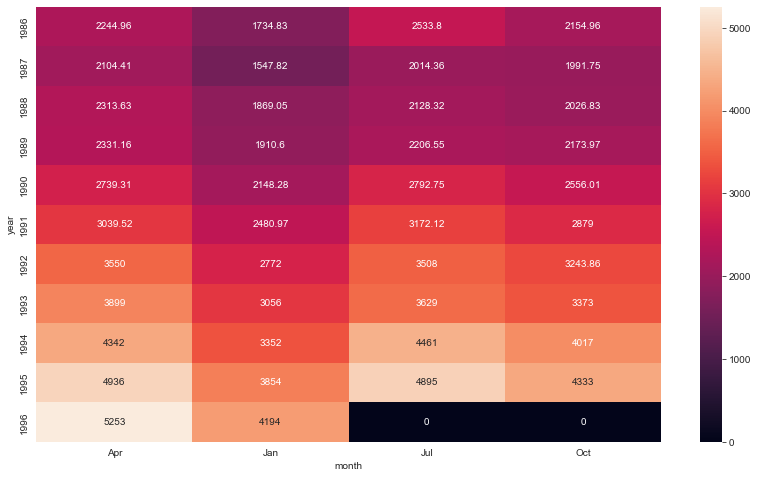

In [314]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cc,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

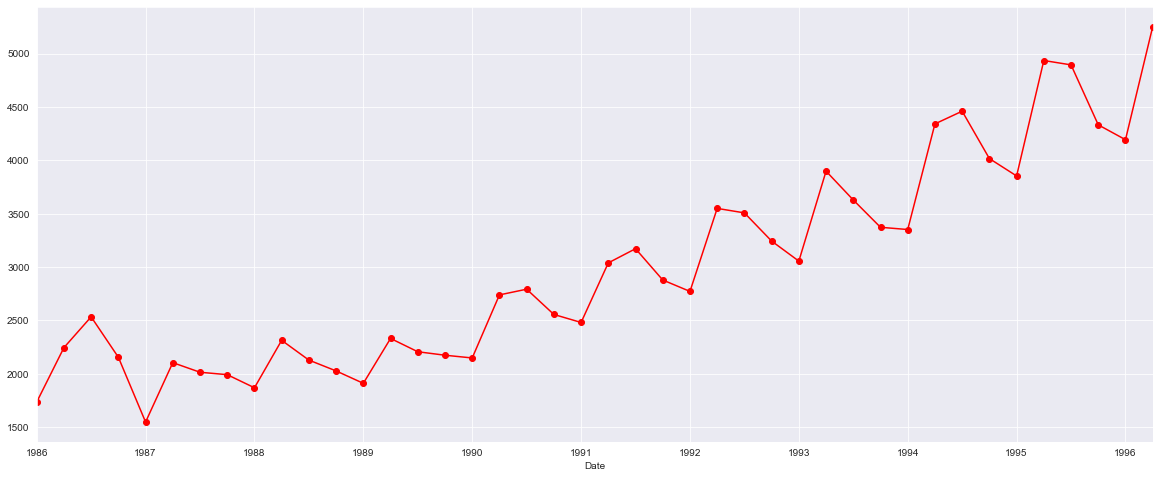

In [315]:
#line plot
data['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()


The Trend is upward but not constant.

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

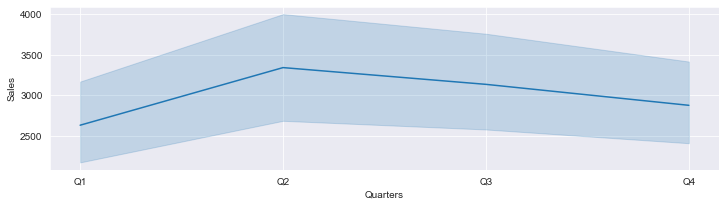

In [316]:
# Line Plot Using Quarters as Y axis and Sales as X axis
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=cc)


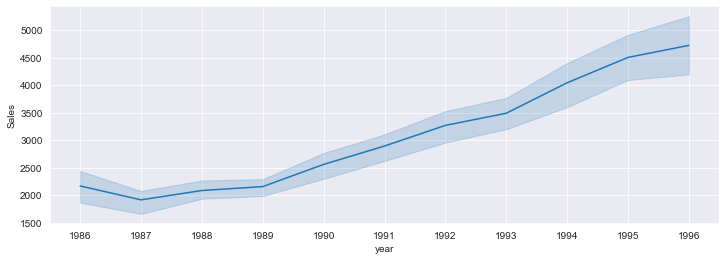

In [317]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=cc)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


<AxesSubplot:xlabel='year', ylabel='Sales'>

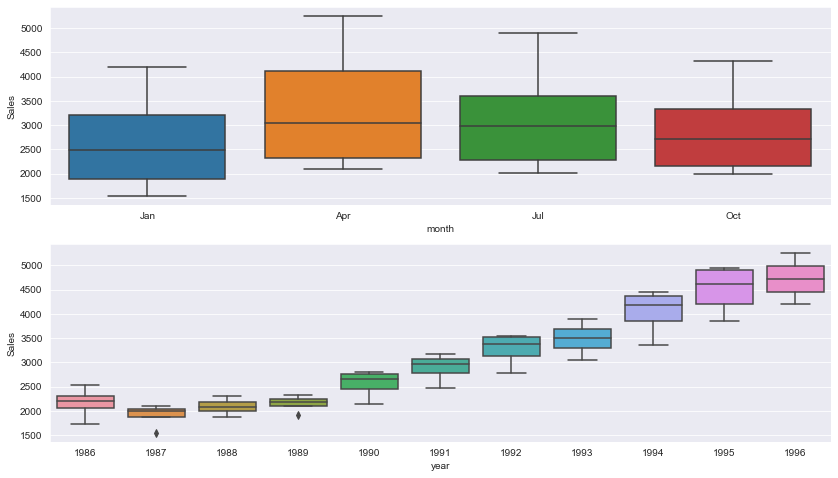

In [318]:
# Box Plot for month & year

plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=cc)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=cc)


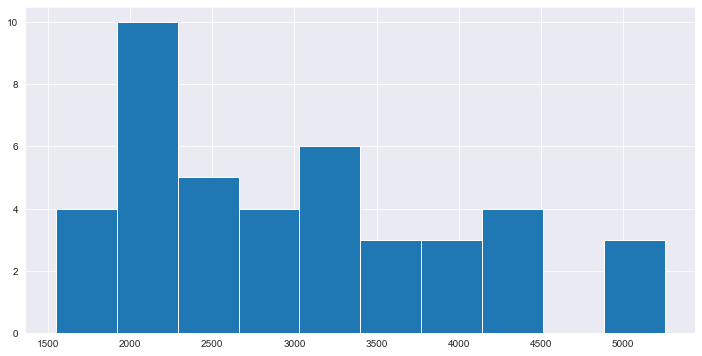

In [319]:
#Histogram
cc.Sales.hist(figsize=(12,6))
plt.show()


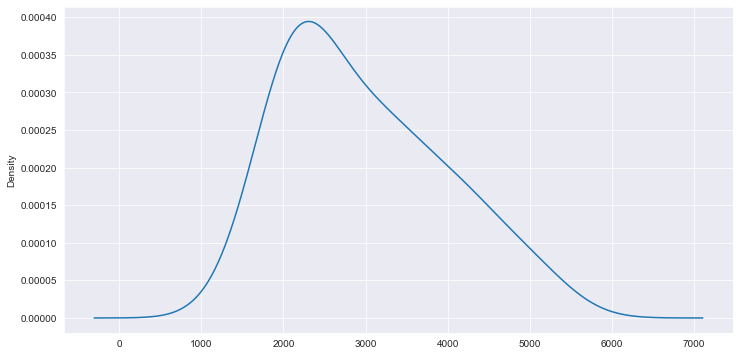

In [320]:
#Density Plot

cc.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

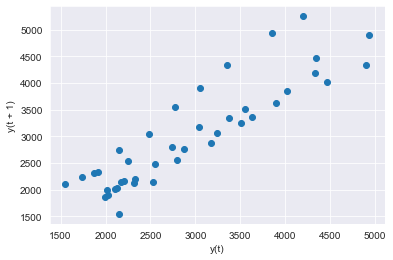

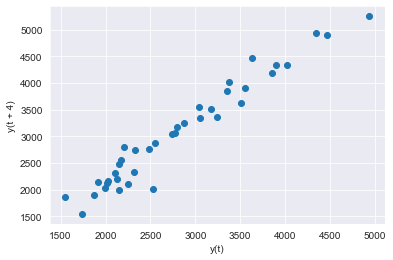

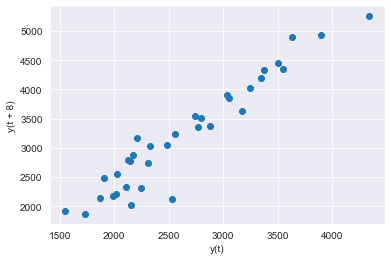

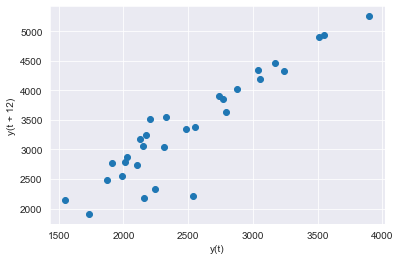

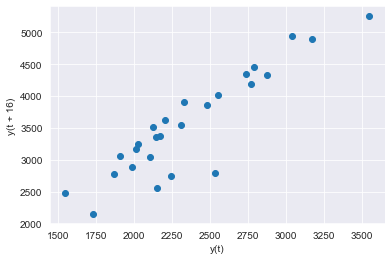

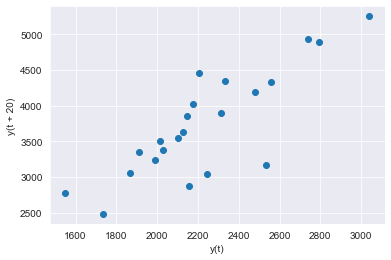

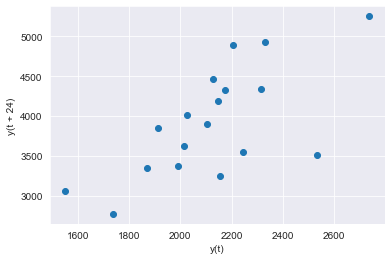

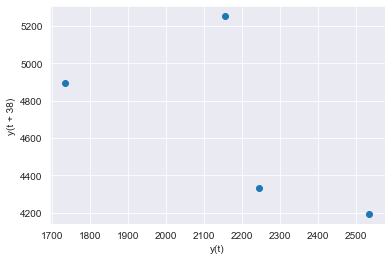

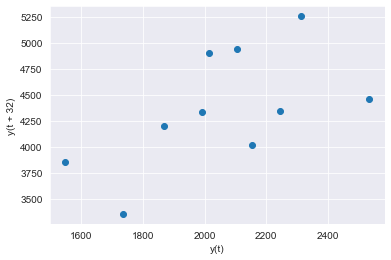

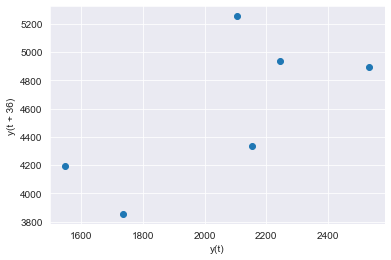

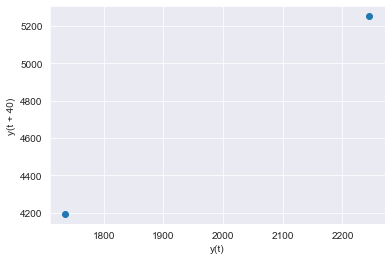

In [321]:
#Scatter Plot using lag
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(cc.Sales, lag=i)
    plt.show()



# Moving Avg.

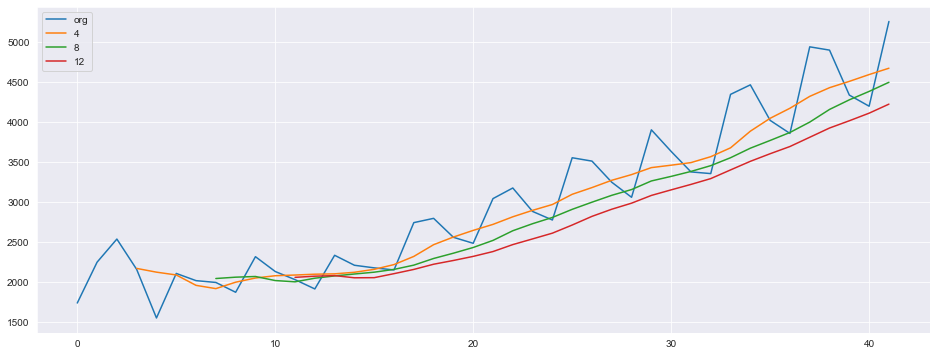

In [322]:
plt.figure(figsize=(16,6))
cc.Sales.plot(label="org")
for i in range(4,13,4):
    cc["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')


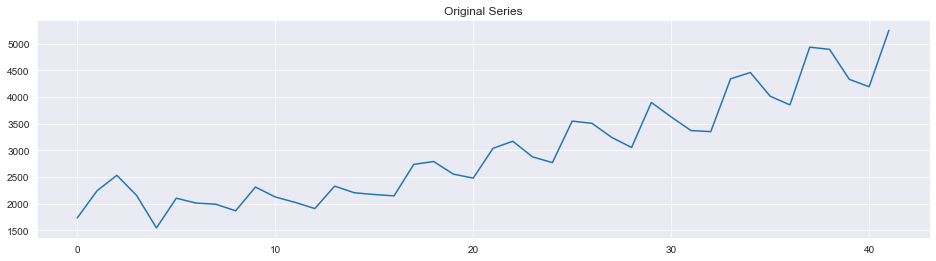

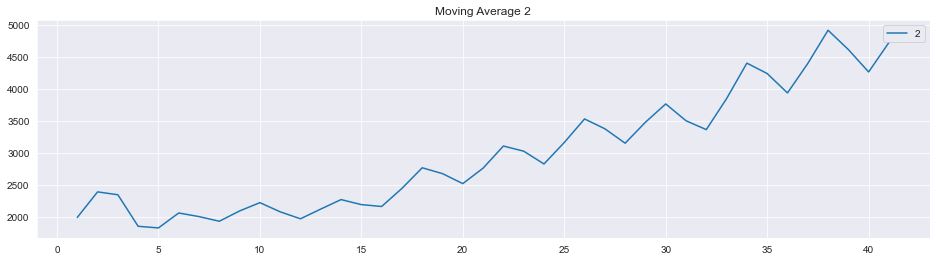

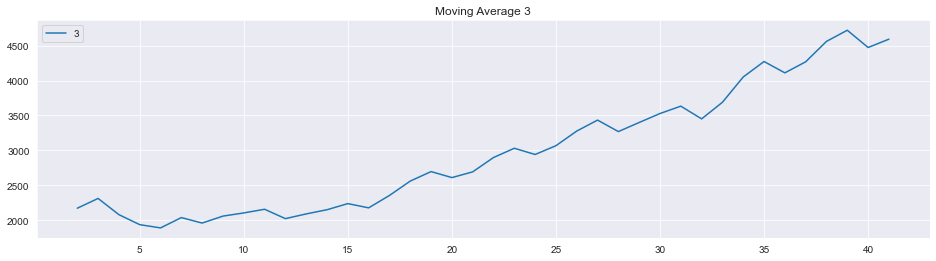

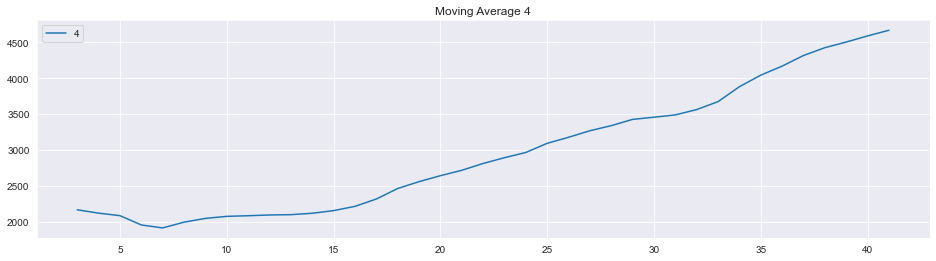

In [323]:
plt.figure(figsize=(16,4))
cc.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    cc["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()


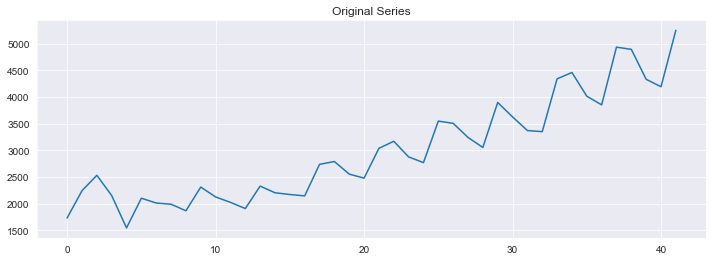

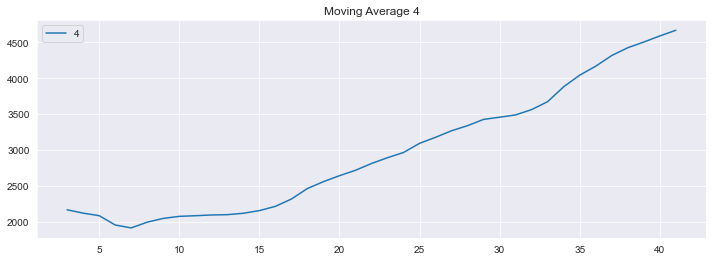

In [324]:
plt.figure(figsize=(12,4))
cc.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
cc["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()


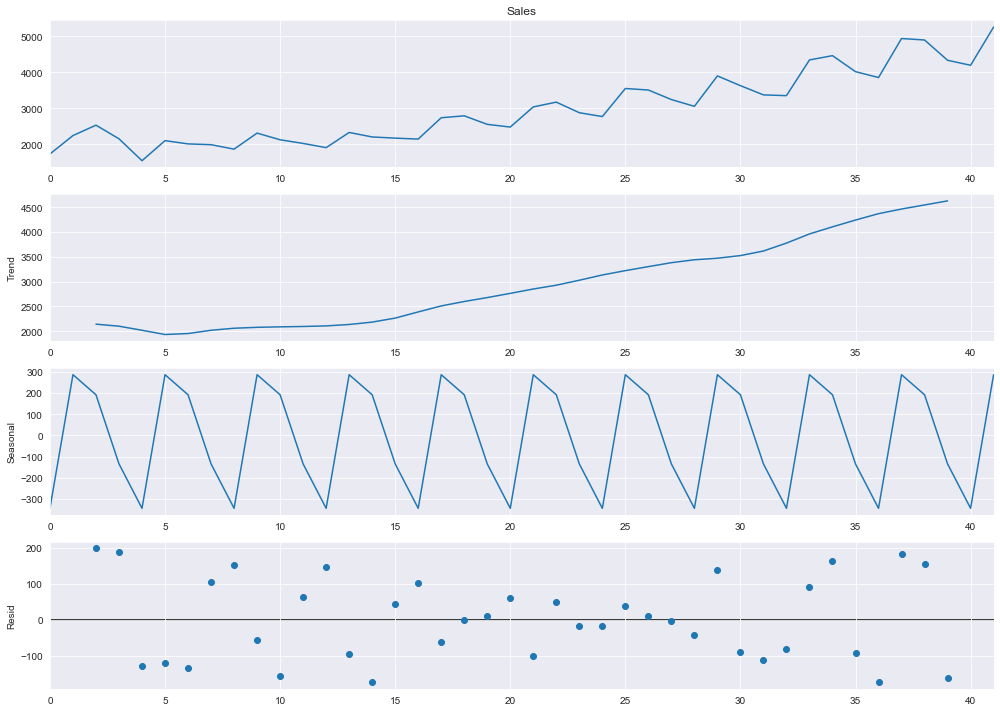

In [325]:
# Time series decomposition plot

decompose_ts_add = seasonal_decompose(cc.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

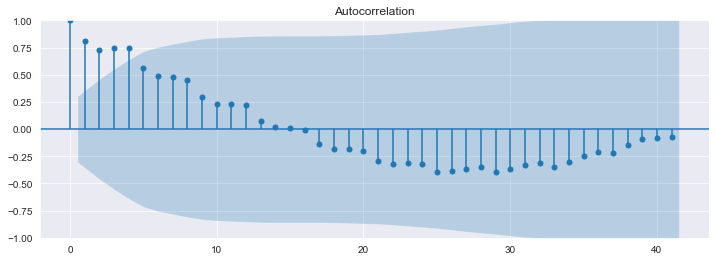

In [326]:
# Autocorrelation Function(ACF)
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(cc.Sales,lags=41)
    plt.show()


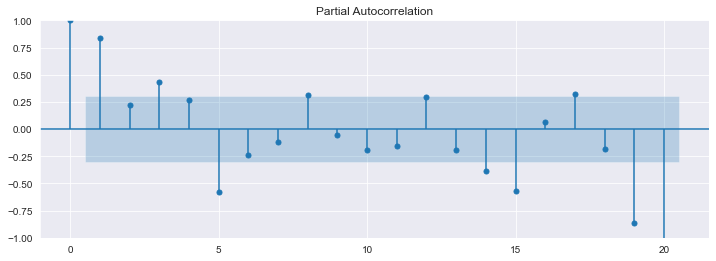

In [327]:
import statsmodels.graphics.tsaplots as tsa_plots       # Partial Autocorrelation Function (PACF Plot)
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(cc.Sales,lags=20)
    plt.show()


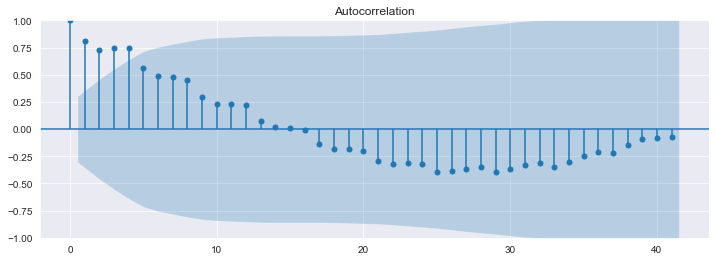

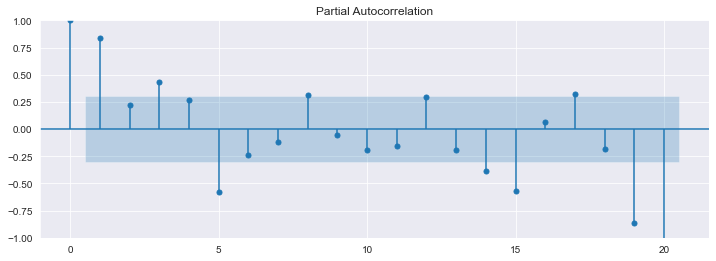

In [328]:
import statsmodels.graphics.tsaplots as tsa_plots          # Plotting ACF & PACF plot together to understand direct correlation between
with plt.rc_context():                                      # Time Series & Lagged version
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(cc.Sales,lags=41)
    tsa_plots.plot_pacf(cc.Sales,lags=20)
    plt.show()


# Linear interpolation
(Implemeting Sampling techniques)

In [145]:
upsampled_month = data.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(15))


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996
1987-02-28          NaN
1987-03-31          NaN


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


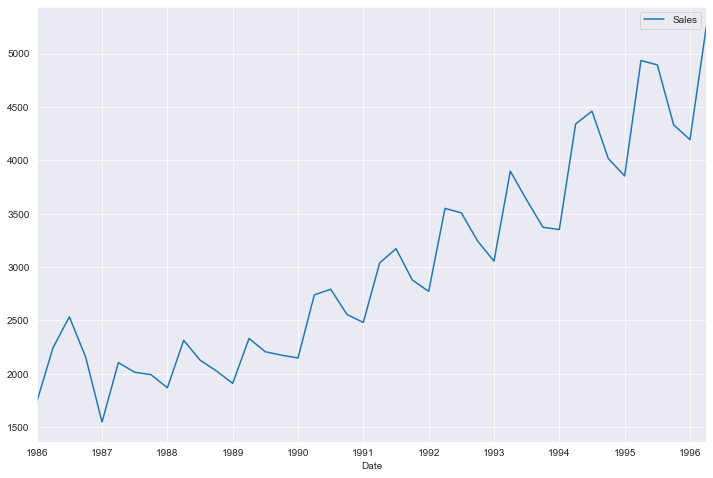

In [146]:
interpolated_month = upsampled_month.interpolate(method='linear') 
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

# interplation was done for nan values which we get after doing upsampling by month

In [147]:
interpolated_month 

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

[124 rows x 1 columns]

In [148]:
vis = interpolated_month.copy()
vis.reset_index(inplace=True)
vis['date'] = pd.to_datetime(vis['Date'])
vis['year'] = vis['Date'].dt.year
vis['month'] = vis['Date'].dt.month
vis['week'] = vis['Date'].dt.isocalendar().week
vis['quarter'] = vis['Date'].dt.quarter
vis['day_of_week'] = vis['Date'].dt.day_name()
vis.drop('Date', axis =1 , inplace= True)
vis[:5]


Sales       date  year  month  week  quarter day_of_week
0  1734.827000 1986-01-31  1986      1     5        1      Friday
1  1904.871666 1986-02-28  1986      2     9        1      Friday
2  2074.916332 1986-03-31  1986      3    14        1      Monday
3  2244.960999 1986-04-30  1986      4    18        2   Wednesday
4  2341.242330 1986-05-31  1986      5    22        2    Saturday

In [149]:
df_1986 = vis[vis['year']==1986][['month','Sales']]
df_1986 = df_1986.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1986'})
df_1987 = vis[vis['year']==1987][['month','Sales']]
df_1987 = df_1987.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1987'})
df_1988 = vis[vis['year']==1988][['month','Sales']]
df_1988 = df_1988.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1988'})
df_1989 = vis[vis['year']==1989][['month','Sales']]
df_1989 = df_1989.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1989'})
df_1990 = vis[vis['year']==1990][['month','Sales']]
df_1990 = df_1990.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1990'})
df_1991 = vis[vis['year']==1991][['month','Sales']]
df_1991 = df_1991.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1991'})
df_1992 = vis[vis['year']==1992][['month','Sales']]
df_1992 = df_1992.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1992'})
df_1993 = vis[vis['year']==1993][['month','Sales']]
df_1993 = df_1993.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1993'})
df_1994 = vis[vis['year']==1994][['month','Sales']]
df_1994 = df_1994.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1994'})
df_1995 = vis[vis['year']==1995][['month','Sales']]
df_1995 = df_1995.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1995'})

df_year = df_1986.merge(df_1987,on='month').merge(df_1988,on='month').merge(df_1989,on='month').merge(df_1990,on='month')\
.merge(df_1991,on='month').merge(df_1992,on='month').merge(df_1993,on='month').merge(df_1994,on='month').merge(df_1995,on='month')

# top levels
top_labels = ['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)'
          ,'rgb(197, 237, 221)','rgb(236, 249, 244)']

# X axis value 
df_year = df_year[['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1986['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1986['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()


* Top Sales happend in June, July, May & April

* From Year 1986 the sales has been rising till year 1995.


In [150]:
# data
import calendar
df_m_sa = vis.groupby('month').agg({"Sales" : "mean"}).reset_index()
df_m_sa['Sales'] = round(df_m_sa['Sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Sales'].astype(str) 

df_w_sa = vis.groupby('week').agg({"Sales" : "mean"}).reset_index() 
df_q_sa = vis.groupby('quarter').agg({"Sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()


In [151]:
# data
df_dw_sa = vis.groupby('day_of_week').agg({"Sales" : "mean"}).reset_index()
df_dw_sa.Sales = round(df_dw_sa.Sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))


* Top Sales happend in April Month(3341)
* Lowest Sales happend in January month(2629)
* In genral the avg sales are upward and increasing  but not constant.
* In Daywise avg sales, highest sales happend on Tuesday(3106) while the lowest on Saturday(2821).

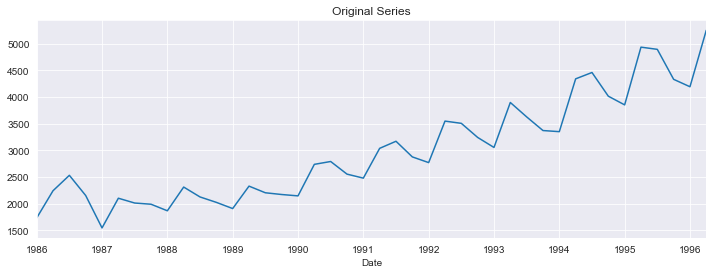

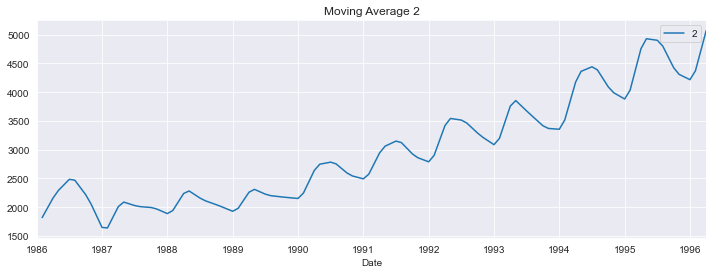

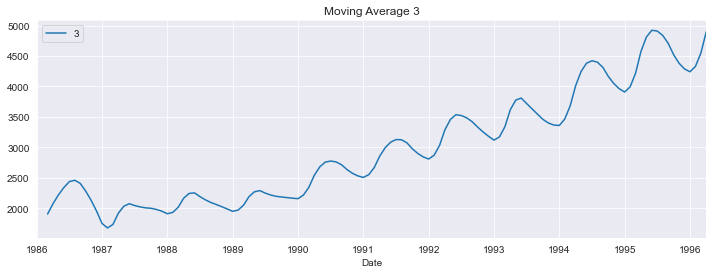

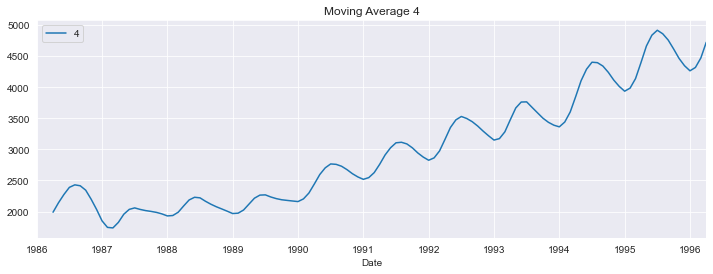

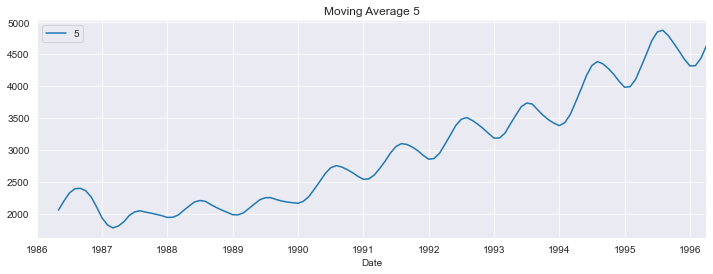

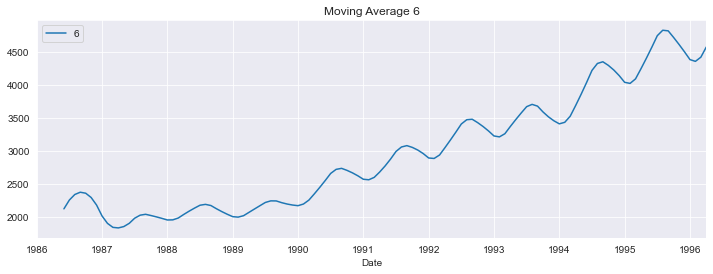

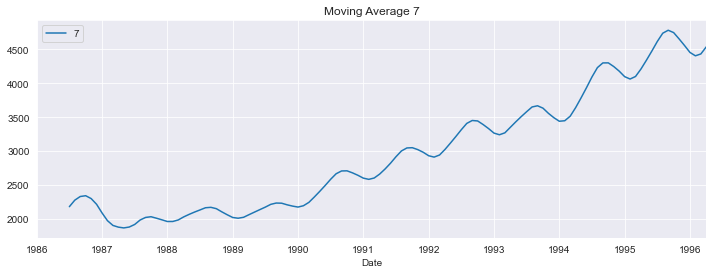

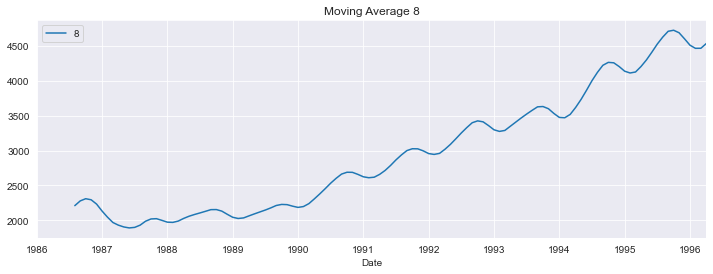

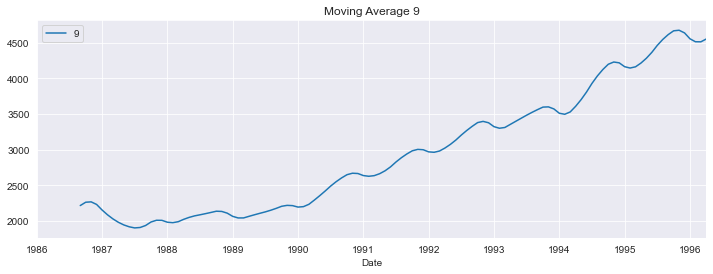

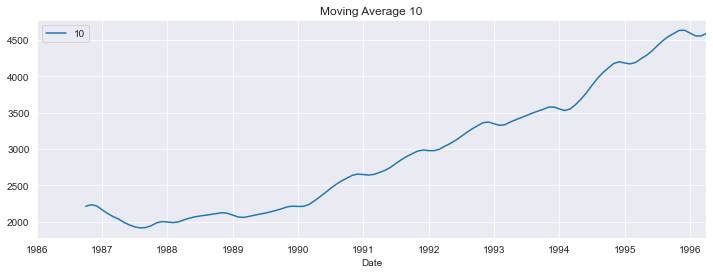

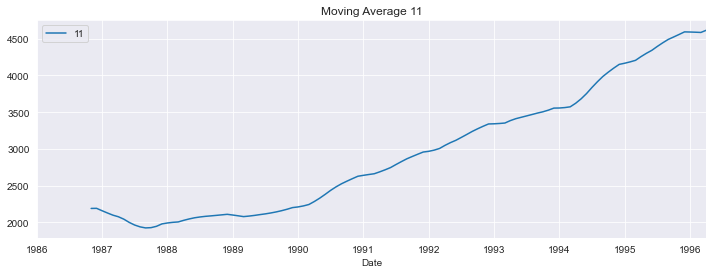

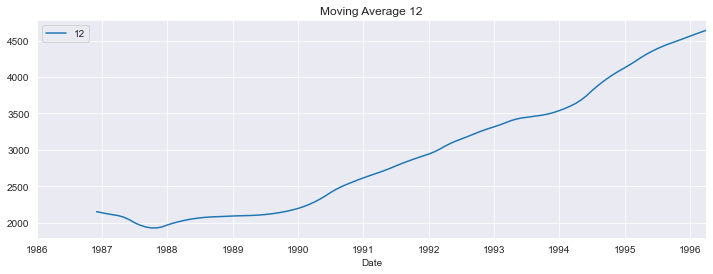

In [152]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()


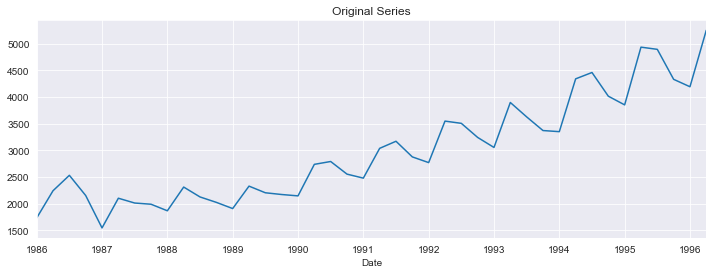

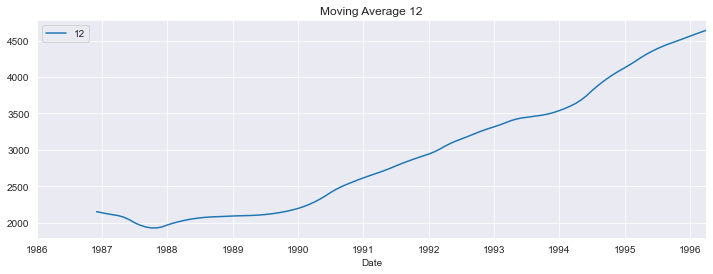

In [153]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()


# Decomposition of Time Series
 (Seasonality & Trend)

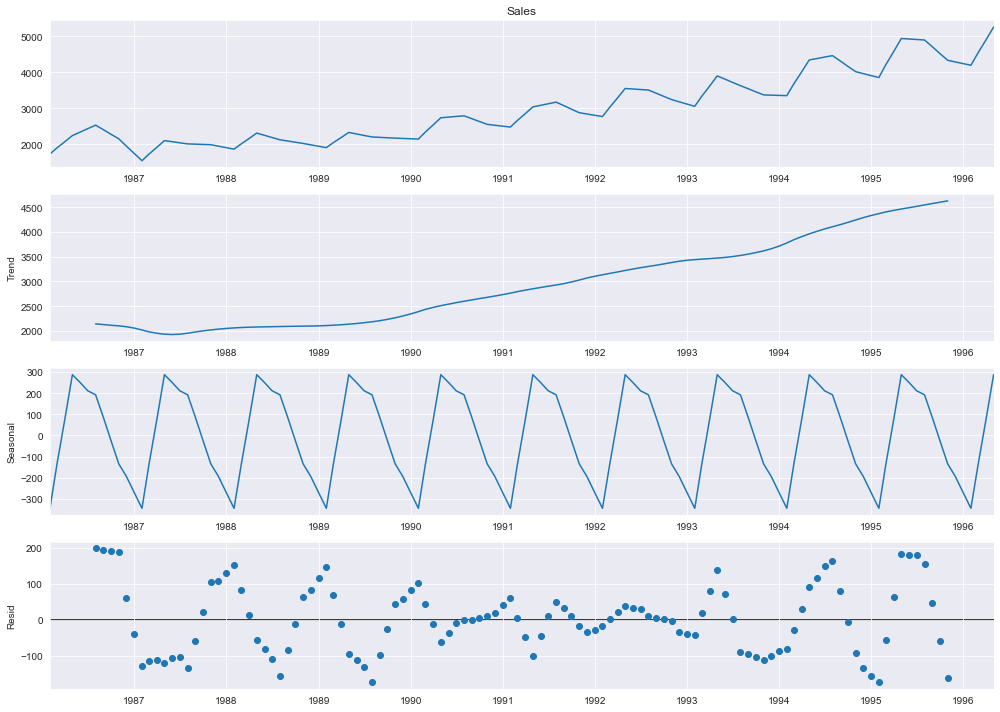

In [154]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()


* Varies from +50 to -50 with the mean 0.

* Each cycle represents each year trend.

* The value in the Y-axis has to be added to the Trend plot value to get the  
  actual value of that year. E.g.:- For the year 1987v, the seasonal value 
  is +50 and the trend value is 100. Hence, teh actual value(passengers number) 
  will (seasonal+Trend) value = 50+100 = 150.

It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

# Multiplicative Seasonal Decomposition

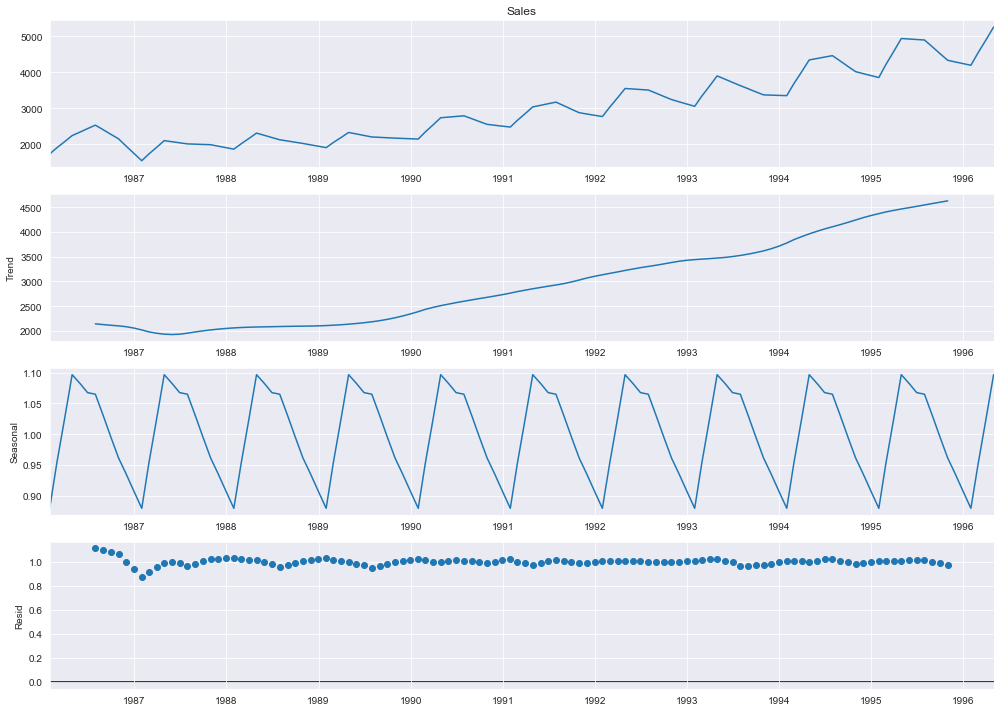

In [155]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()


Varies from 0.8 to 1.2

The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year. E.g.:- For the year 1995 Nov, the seasonal value is 1.2 and the trend value is 100. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.

# Splitting the data into Train and Test 

In [156]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]


In [202]:
train_data

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1993-12-31  3359.000000
1994-01-31  3352.000000
1994-02-28  3682.000000
1994-03-31  4012.000000
1994-04-30  4342.000000

[100 rows x 1 columns]

In [203]:
test_data

Sales
Date                   
1994-05-31  4381.666667
1994-06-30  4421.333333
1994-07-31  4461.000000
1994-08-31  4313.000000
1994-09-30  4165.000000
1994-10-31  4017.000000
1994-11-30  3962.666667
1994-12-31  3908.333333
1995-01-31  3854.000000
1995-02-28  4214.666667
1995-03-31  4575.333333
1995-04-30  4936.000000
1995-05-31  4922.333333
1995-06-30  4908.666667
1995-07-31  4895.000000
1995-08-31  4707.666667
1995-09-30  4520.333333
1995-10-31  4333.000000
1995-11-30  4286.666667
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

In [204]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())


Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


doing the forecastin for the last two years.(1986 & 1994) 

Last 24 records contain 1994 and 1996 data.

<AxesSubplot:xlabel='Date'>

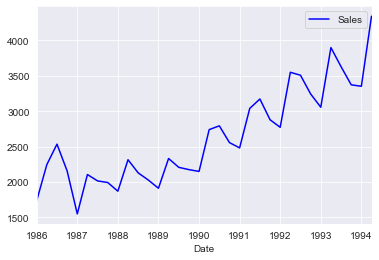

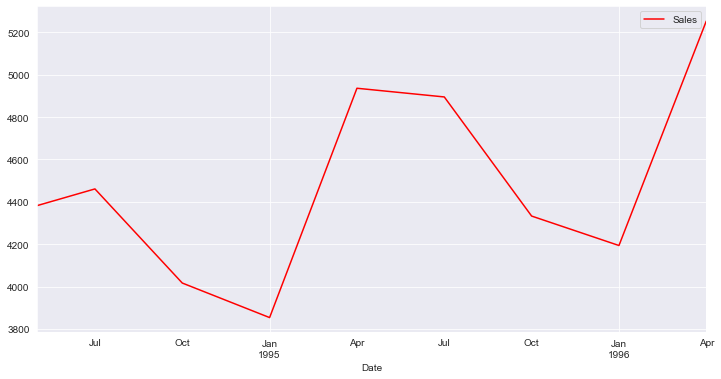

In [158]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')



# Evaluation Metric MAPE

In [159]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)


# Exponential Methods
(Using Forecast Attribute)


In [160]:
# Using Predict Attribute
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))


Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.619719427225402 
 Train Root Mean Squared Error = 129.37951453141417 
 Test Root Mean Squared Error = 381.95422355078995


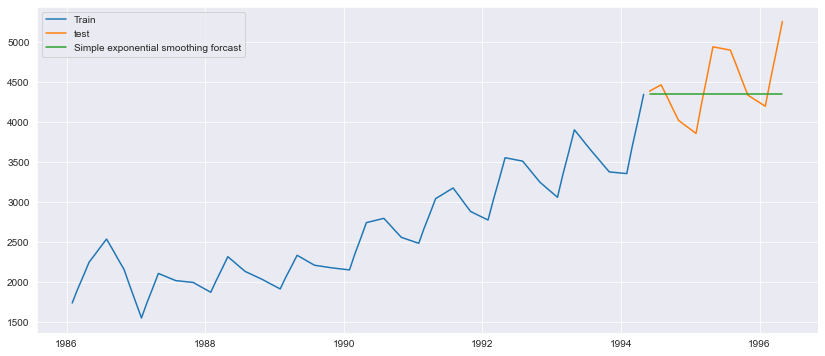

In [161]:
# Plot the difference between predict & Forecast attribute

plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()


Seasonality pattern haven't seen here!

recent one gets higher weightage than older one.

# Holt method (Double Exponential)

Captures both Level and Trend


In [162]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))


Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.7001615463704 
 Train Root Mean Squared Error = 108.58347720512378 
 Test Root Mean Squared Error = 4560.457728458048


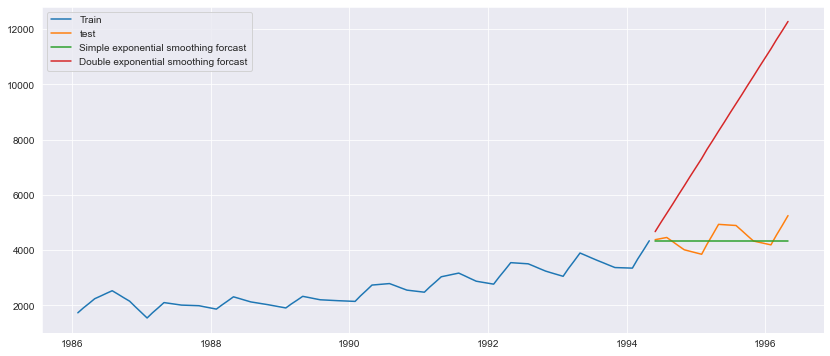

In [163]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()



* Here we are able to capture the trend of the data

* We were not able to capture the seasonality.

# Triple Exponential
(Holts winter exponential smoothing with additive seasonality and trend)

Captures Level, Trend and Seasonality

In [164]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))



Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 34.23944156457067 
 Train Root Mean Squared Error = 44.17572264662261 
 Test Root Mean Squared Error = 1758.7055544098644


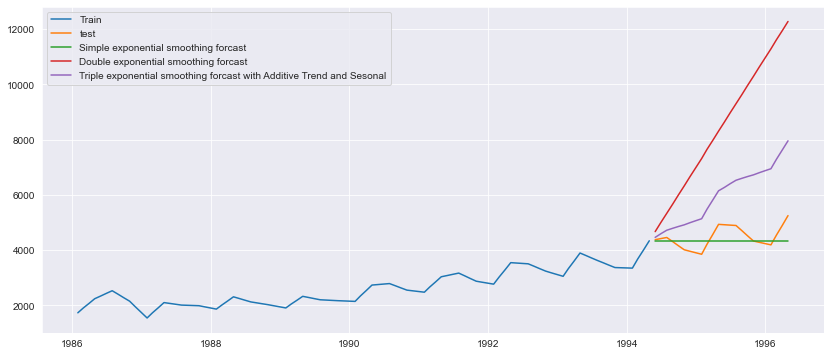

In [165]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()


* Here you can see, able to catch the trend & the forecasted values are higher   than test levels.
* Tracing the seasonality as well.
* The peak of forecasted value are higher than actual.

# Triple Exponential
(Holts winter exponential smoothing with multiplicative seasonality and additive trend)

In [166]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))


Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.483298493452904 
 Train Root Mean Squared Error = 50.22454696270186 
 Test Root Mean Squared Error = 78.3845682517769


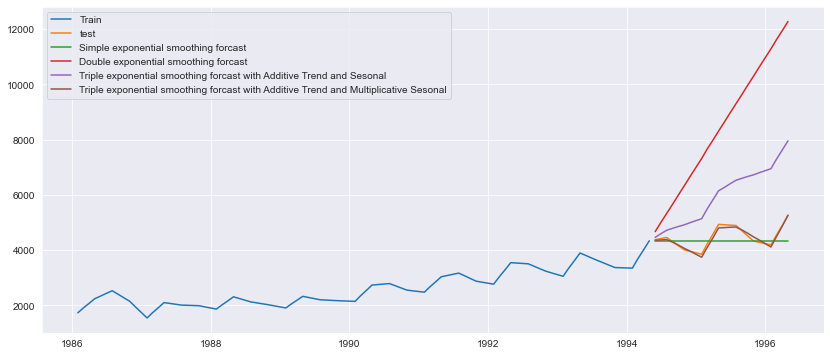

In [167]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()



Here can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

# Triple Exponential
(Holts winter exponential smoothing with Additive seasonality and multiplicative trend)

In [168]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))


Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 5.157134449259166 
 Train Root Mean Squared Error = 166.60624759961158 
 Test Root Mean Squared Error = 269.5054193081448


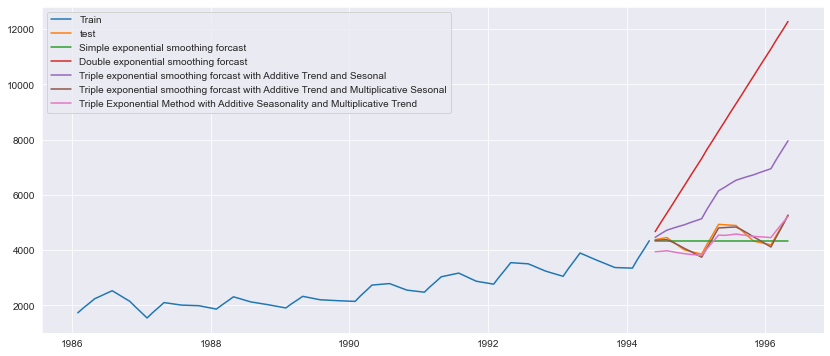

In [169]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()


# Triple Exponential
(Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend)

In [170]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))


Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 2.6327808147458014 
 Train Root Mean Squared Error = 42.561957415060434 
 Test Root Mean Squared Error = 168.8434861791096


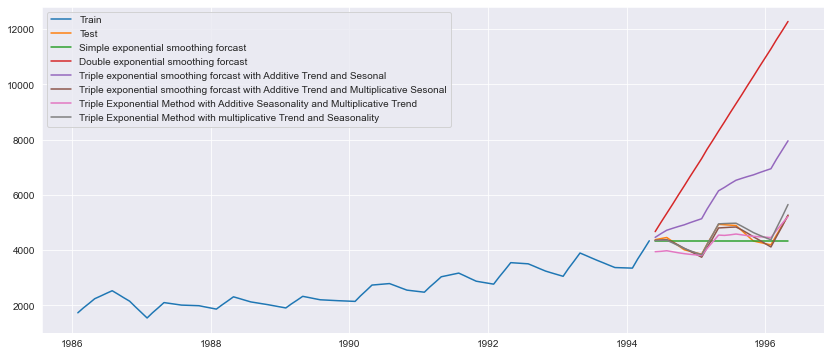

In [171]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

# Results Comparision

In [172]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad   50.224547      1.483298         78.384568
1     Triple_Exp_mul   42.561957      2.632781        168.843486
2  Triple_Exp_ad_mul  166.606248      5.157134        269.505419
3         Simple_Exp  129.379515      6.619719        381.954224
4      Triple_Exp_ad   44.175723     34.239442       1758.705554
5         Double_Exp  108.583477     89.700162       4560.457728

# Model Visualization

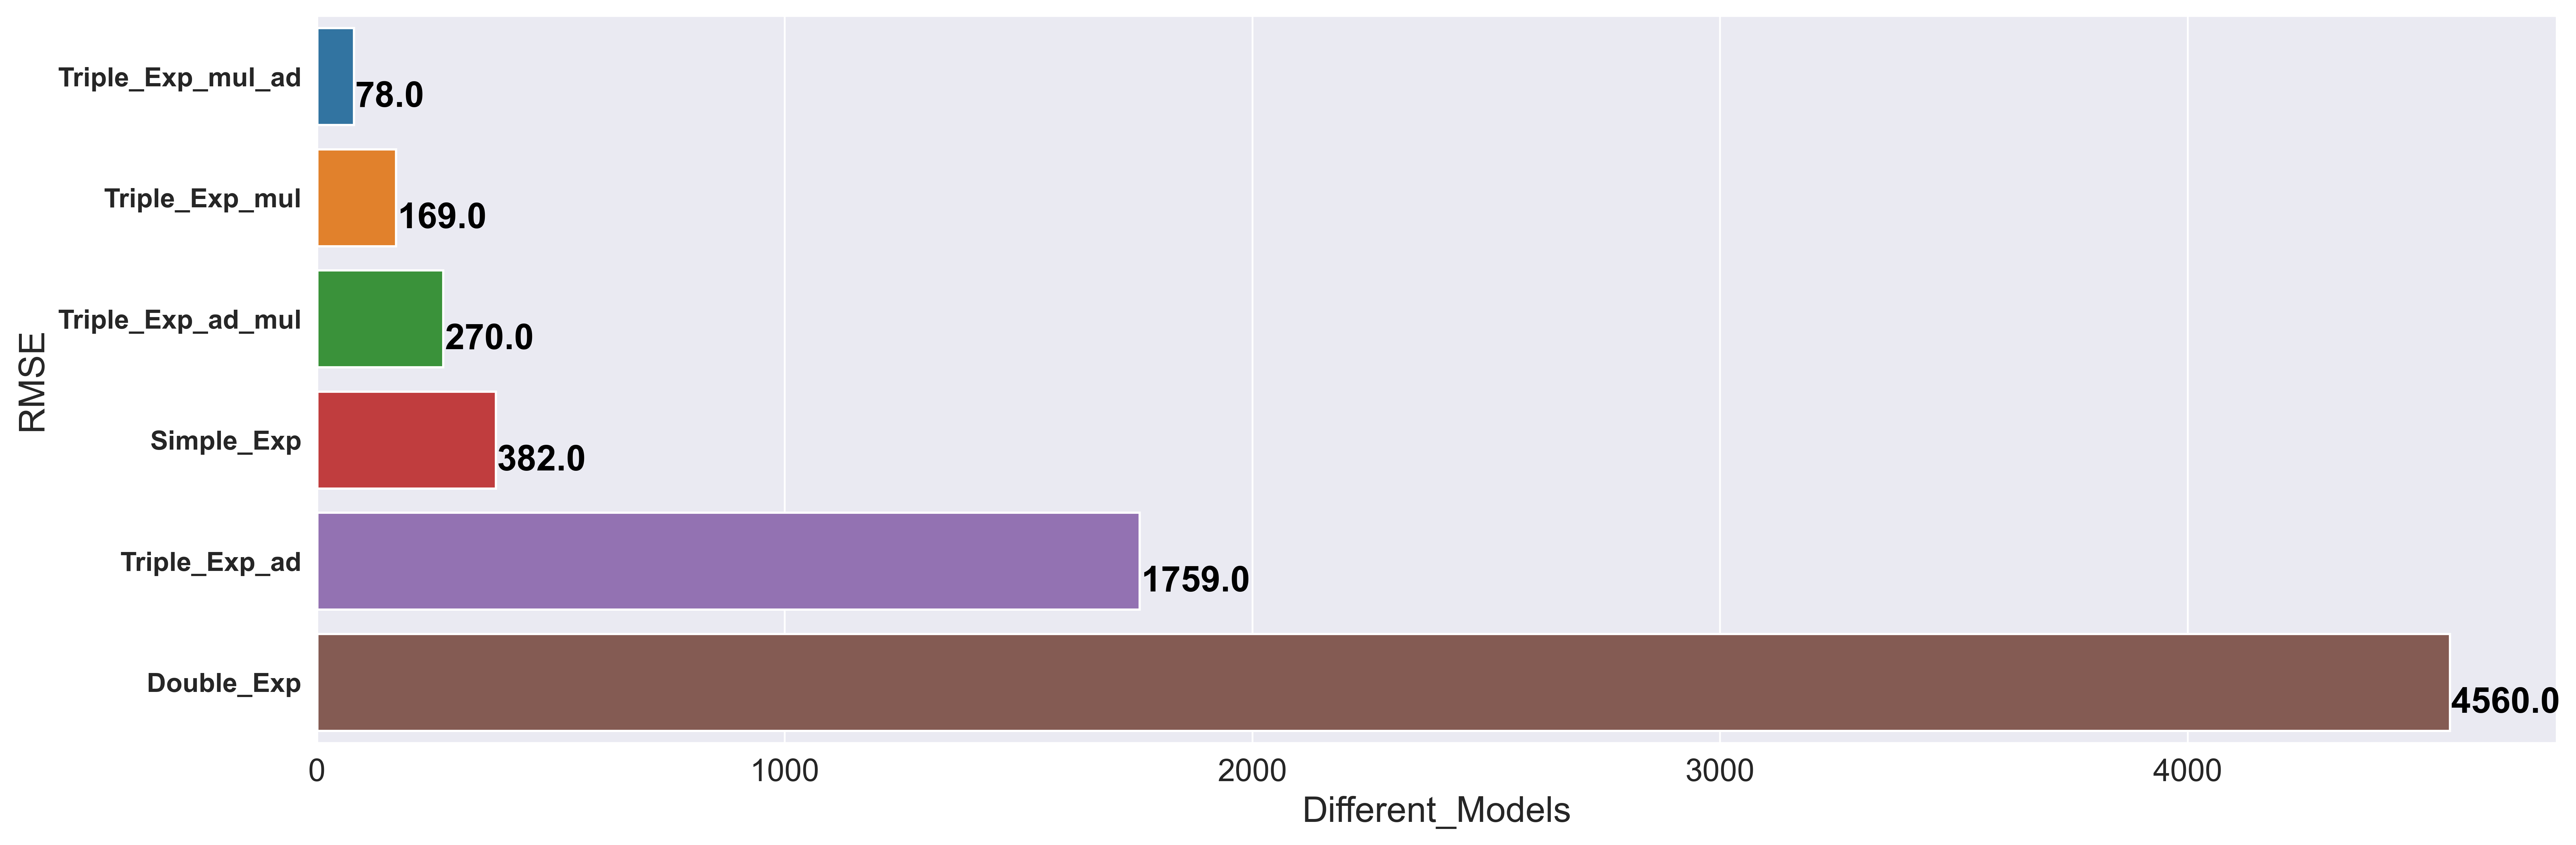

In [173]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()


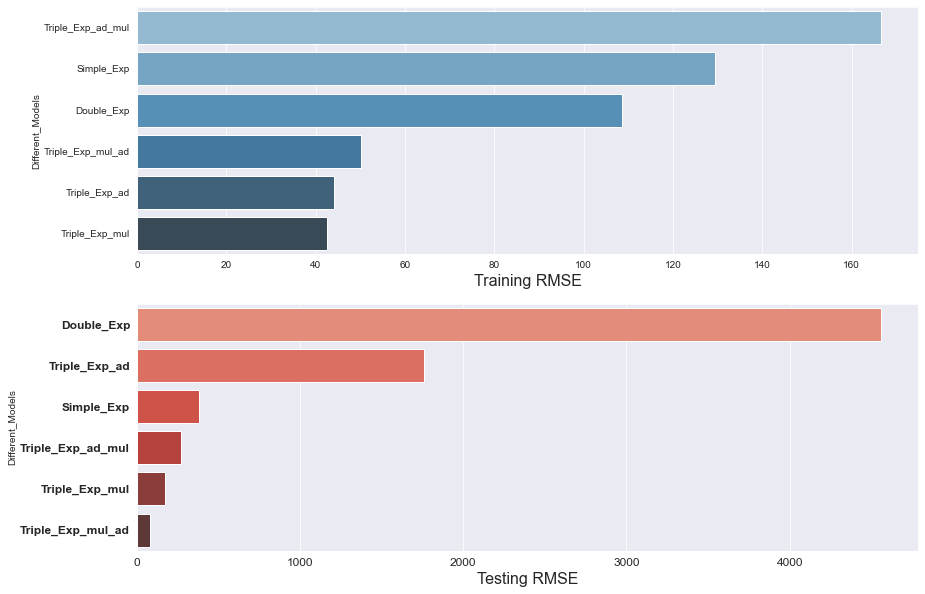

In [174]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# ARIMA
(Autoregressive Integrated Moving Averages)

In [175]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Null Hypothesis (HO) = The Series is not Staionary

Alt Hypothesi(H1) = The Series is Staionary

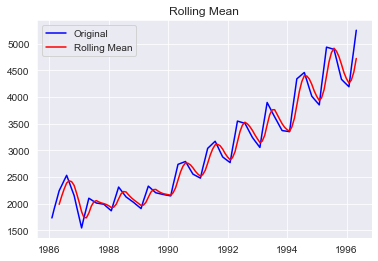

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [176]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)



Augmented Dicky Fuller Test

In [177]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")



In [178]:
adf_test(sales.Sales)


Fail to reject the null hypothesis
Data is non-stationary


# Transformations(Feature Scaling)


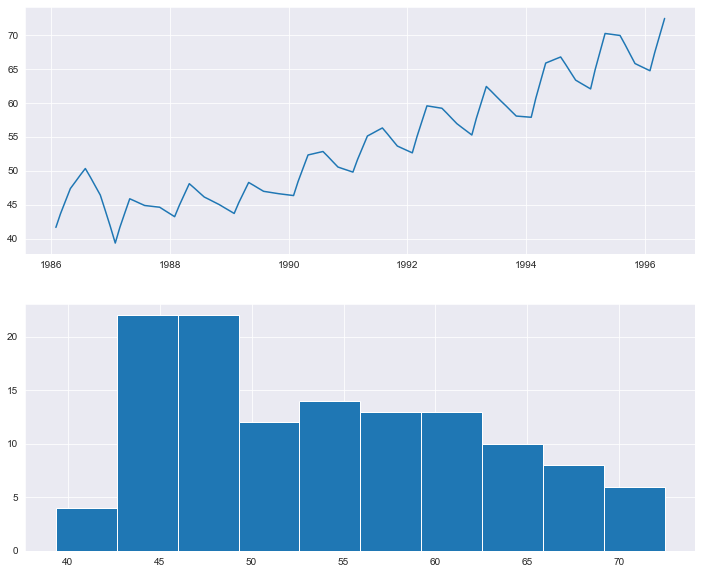

In [179]:
# Square Root Transformation

square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()


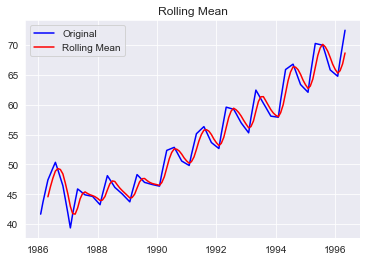

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [180]:
test_stationarity(square_root)


In [181]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


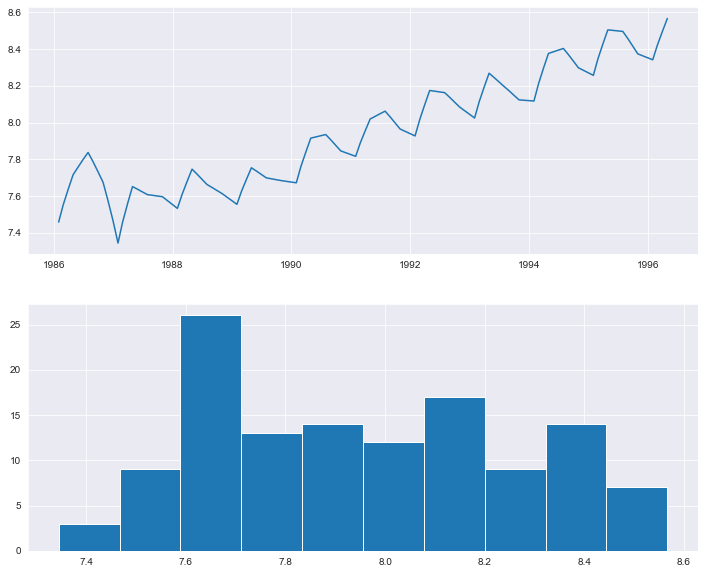

In [182]:
# Log Transform

log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()



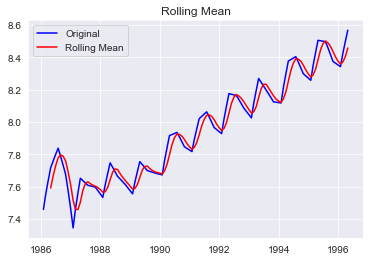

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [183]:
test_stationarity(log)

In [184]:
adf_test(log.Sales)


Fail to reject the null hypothesis
Data is non-stationary


# Converting Non-Stationary Time Series into Stationary

Box Cox Transformation

Sales
Date                
1986-01-31  7.458663
1986-02-28  7.552170
1986-03-31  7.637676
1986-04-30  7.716443
1986-05-31  7.758437

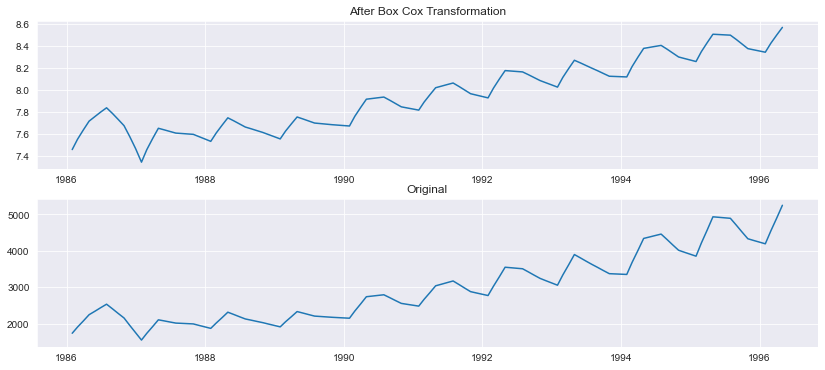

In [185]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()



* Here you can see a variance became almost constant after the transformation. 
* Previous & after years both variance is a bit similar.
* But the series still has an upward trend. it shows the mean is not constant yet. 

So need to apply Differencing method for making the mean constant.

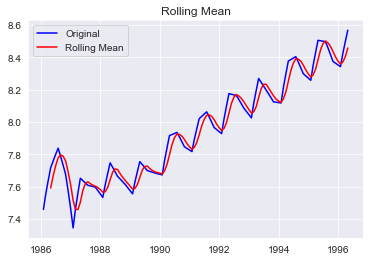

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [186]:
test_stationarity(data_boxcox)

In [187]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


# Differencing of the Box-Cox Transformation

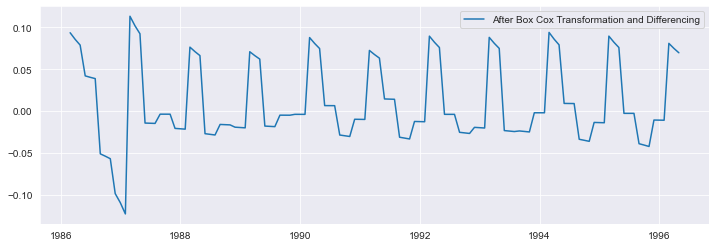

In [188]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()





No trend seen in Box cox Differncing. Its horizontal trend. Need to do the stationarity again

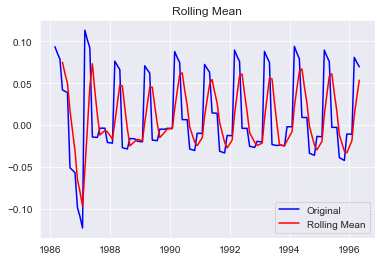

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [189]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)


In [190]:
adf_test(data_boxcox_diff.Sales)


Reject the null hypothesis
Data is stationary


Finally, Our Series is now stationary for AR Forecasting

In [206]:
from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA


In [207]:
data_boxcox_diff.head()

Sales
Date                
1986-02-28  0.093507
1986-03-31  0.085506
1986-04-30  0.078767
1986-05-31  0.041994
1986-06-30  0.040301

# Building The Time Series Forecasting with Optimal Value using ARIMA

In [208]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]


we did converted the original time series to Stationary series by consecutively applying BoxCox transformation and Differencing. We have to transform the series back to the original one
(step by step).

In [209]:
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])


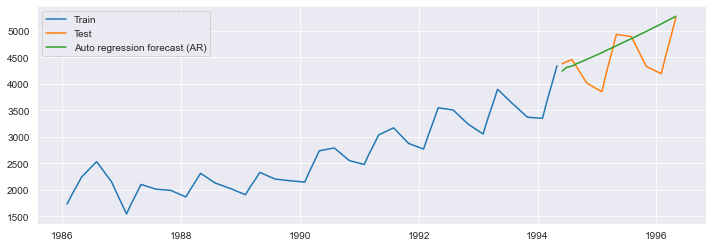

In [210]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()


No Seasonality captured. Only Trend has been captured

#  Evaluation of Model

In [211]:
# Root Mean Squared Error(RMSE)
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['ar_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA


463.89

In [214]:
mape_arima =MAPE(y_hat_ar['ar_forecast'],test_data.Sales)
mape_arima

8.706076769261221

We can see that AR model has done reasonably good job

# Residual Analysis

In [217]:
model_residual = model_fit.resid
model_residual.mean()


0.00020506455755519524

In [216]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


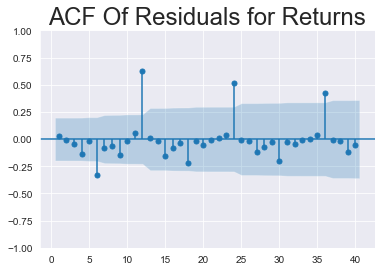

In [218]:
plot_acf(model_residual, zero = False, lags = 40)    # ACF Plot
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()


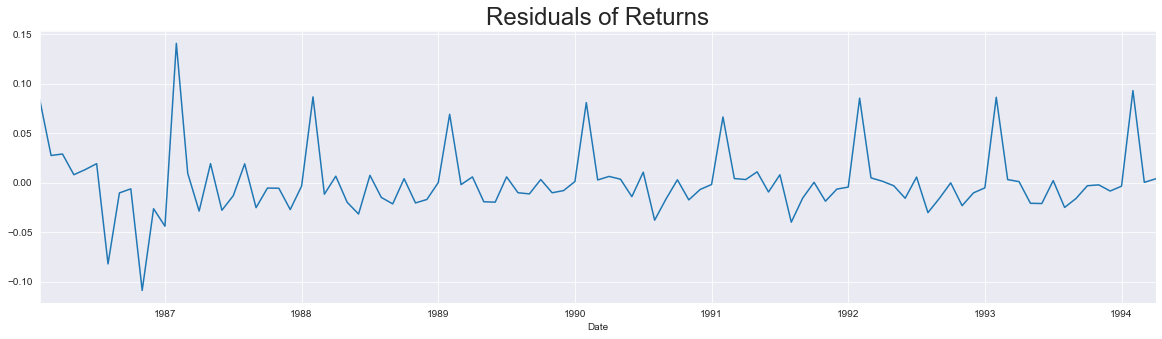

In [219]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)   # Random Residuals
plt.show()

# SARIMA
(Seasonal Auto Regressive Integrated Moving Average)
ARIMA with Seasonal component added.

In [226]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [227]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])


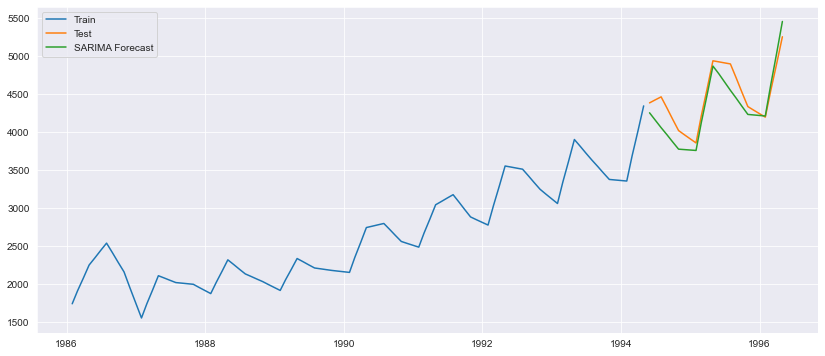

In [229]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()


# Evaluation of Model

In [230]:
#Root Mean Squared Error(RMSE)
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA


205.04

In [231]:
#Mean Absolute Percent Error(MAPE)

In [233]:

mape_SARIMA= MAPE(y_hat_sarima['sarima_forecast'],test_data.Sales)
mape_SARIMA


3.9322168481485598

In [234]:
model_residual = model_fit.resid
model_residual.mean()


0.03705054134039066

SARIMA method has done reasonably well as it captures seasonality.

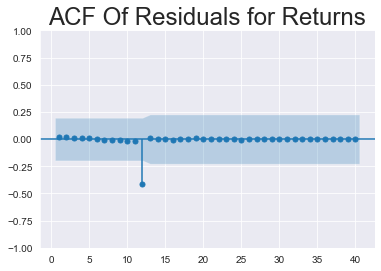

In [235]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

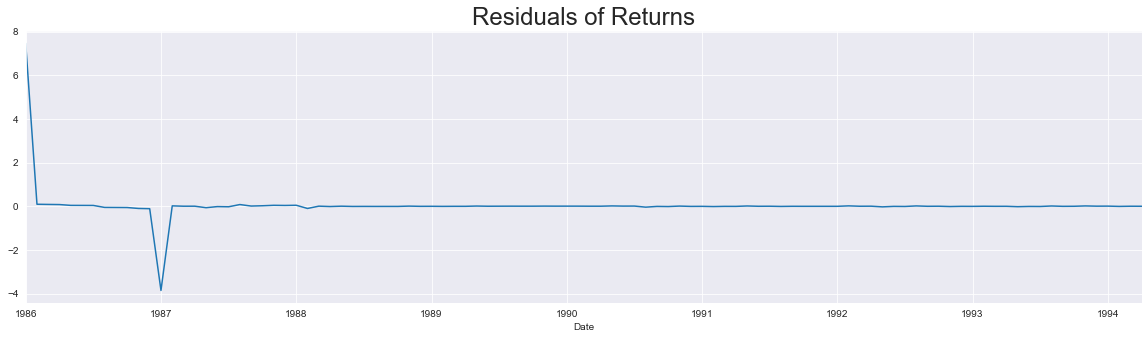

In [236]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()


# Building model with differente Transformation Technique

In [329]:
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_SARIMA]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation


Models    MAPE(%)  RMSE_Values
0          Triple_Exp_mul_ad   1.483298    78.384568
1  Triple_Exp_multiplicative   2.632781   168.843486
2                     SARIMA   3.932217   205.040000
3          Triple_Exp_ad_mul   5.157134   269.505419
4         Simple_Exponential   6.619719   381.954224
5                      ARIMA   8.706077   463.890000
6        Triple_Exp_additive  34.239442  1758.705554
7         Double_Exponential  89.700162  4560.457728

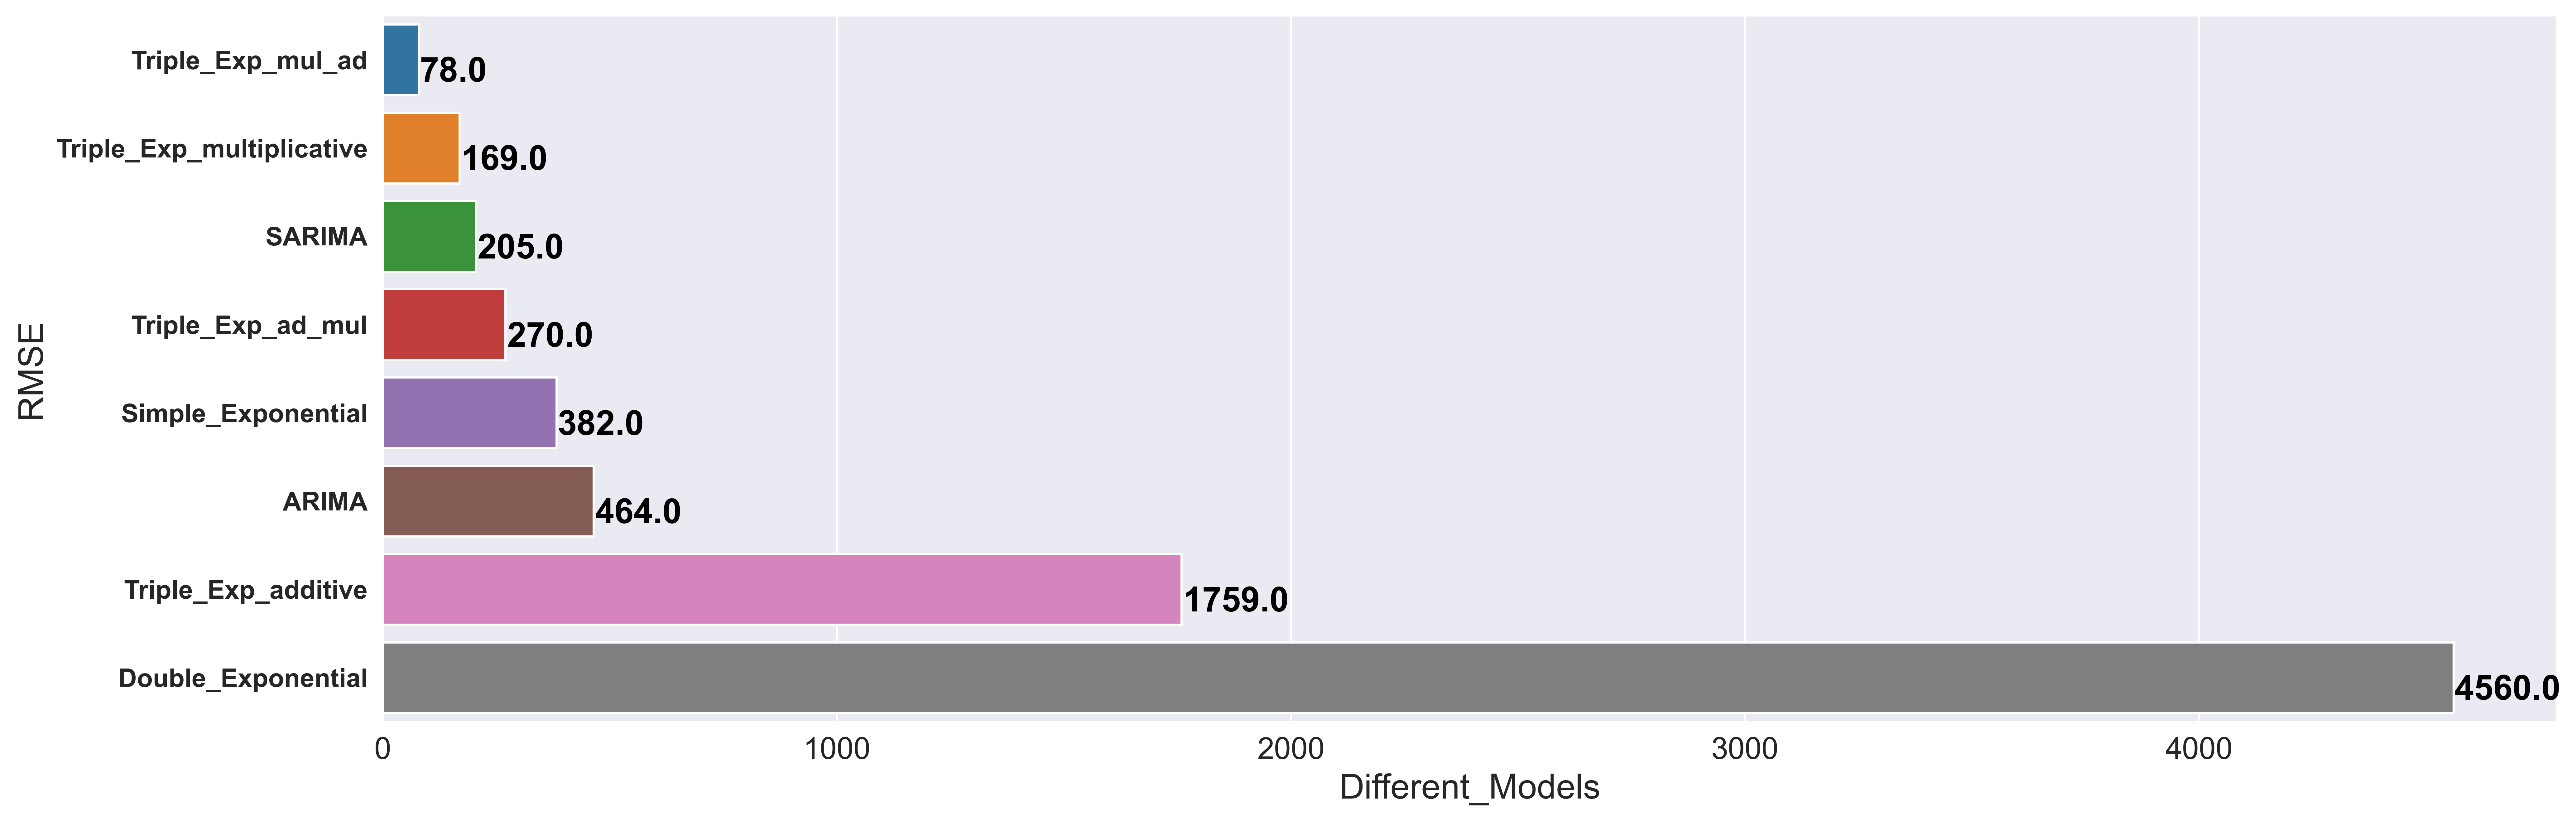

In [330]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

# Data Pre-processing for Model 

Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [261]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola


index       Date        Sales    t  t_squared month  year  Jan  Feb  Mar  \
0        0 1986-01-31  1734.827000    1          1   Jan  1986    1    0    0   
1        1 1986-02-28  1904.871666    2          4   Feb  1986    0    1    0   
2        2 1986-03-31  2074.916332    3          9   Mar  1986    0    0    1   
3        3 1986-04-30  2244.960999    4         16   Apr  1986    0    0    0   
4        4 1986-05-31  2341.242330    5         25   May  1986    0    0    0   
..     ...        ...          ...  ...        ...   ...   ...  ...  ...  ...   
119    119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0   
120    120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0   
121    121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0   
122    122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1   
123    123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0   

     Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0      0    0    0    0    0    0    0    0    0   7.458663  
1      0    0    0    0    0    0    0    0    0   7.552170  
2      0    0    0    0    0    0    0    0    0   7.637676  
3      1    0    0    0    0    0    0    0    0   7.716443  
4      0    1    0    0    0    0    0    0    0   7.758437  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...        ...  
119    0    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0    0   8.496990  
123    1    0    0    0    0    0    0    0    0   8.566555  

[124 rows x 20 columns]

<AxesSubplot:xlabel='month', ylabel='year'>

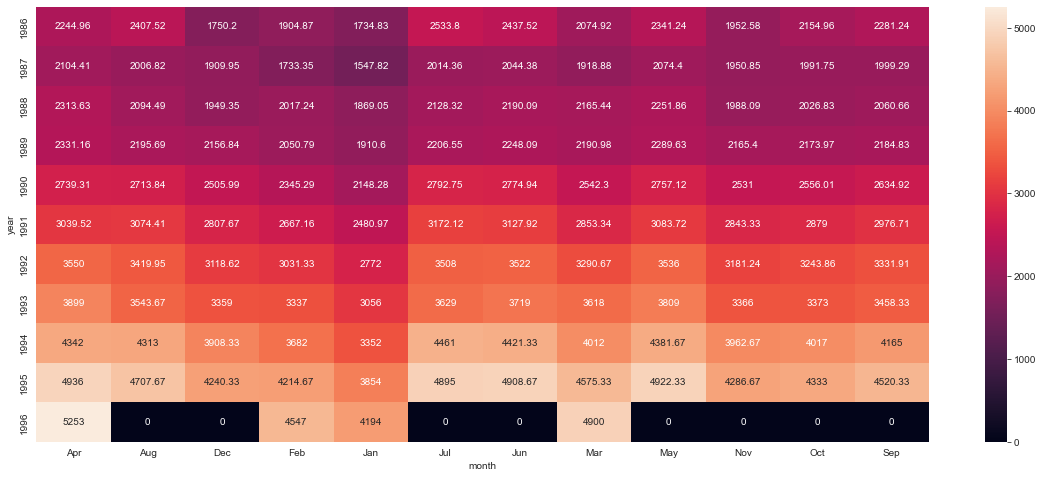

In [262]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

# Splitting data into Train and Test

In [263]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]


In [264]:
train_data

index       Date        Sales    t  t_squared month  year  Jan  Feb  Mar  \
0       0 1986-01-31  1734.827000    1          1   Jan  1986    1    0    0   
1       1 1986-02-28  1904.871666    2          4   Feb  1986    0    1    0   
2       2 1986-03-31  2074.916332    3          9   Mar  1986    0    0    1   
3       3 1986-04-30  2244.960999    4         16   Apr  1986    0    0    0   
4       4 1986-05-31  2341.242330    5         25   May  1986    0    0    0   
..    ...        ...          ...  ...        ...   ...   ...  ...  ...  ...   
95     95 1993-12-31  3359.000000   96       9216   Dec  1993    0    0    0   
96     96 1994-01-31  3352.000000   97       9409   Jan  1994    1    0    0   
97     97 1994-02-28  3682.000000   98       9604   Feb  1994    0    1    0   
98     98 1994-03-31  4012.000000   99       9801   Mar  1994    0    0    1   
99     99 1994-04-30  4342.000000  100      10000   Apr  1994    0    0    0   

    Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0     0    0    0    0    0    0    0    0    0   7.458663  
1     0    0    0    0    0    0    0    0    0   7.552170  
2     0    0    0    0    0    0    0    0    0   7.637676  
3     1    0    0    0    0    0    0    0    0   7.716443  
4     0    1    0    0    0    0    0    0    0   7.758437  
..  ...  ...  ...  ...  ...  ...  ...  ...  ...        ...  
95    0    0    0    0    0    0    0    0    1   8.119399  
96    0    0    0    0    0    0    0    0    0   8.117312  
97    0    0    0    0    0    0    0    0    0   8.211211  
98    0    0    0    0    0    0    0    0    0   8.297045  
99    1    0    0    0    0    0    0    0    0   8.376090  

[100 rows x 20 columns]

In [265]:
test_data

index       Date        Sales    t  t_squared month  year  Jan  Feb  Mar  \
100    100 1994-05-31  4381.666667  101      10201   May  1994    0    0    0   
101    101 1994-06-30  4421.333333  102      10404   Jun  1994    0    0    0   
102    102 1994-07-31  4461.000000  103      10609   Jul  1994    0    0    0   
103    103 1994-08-31  4313.000000  104      10816   Aug  1994    0    0    0   
104    104 1994-09-30  4165.000000  105      11025   Sep  1994    0    0    0   
105    105 1994-10-31  4017.000000  106      11236   Oct  1994    0    0    0   
106    106 1994-11-30  3962.666667  107      11449   Nov  1994    0    0    0   
107    107 1994-12-31  3908.333333  108      11664   Dec  1994    0    0    0   
108    108 1995-01-31  3854.000000  109      11881   Jan  1995    1    0    0   
109    109 1995-02-28  4214.666667  110      12100   Feb  1995    0    1    0   
110    110 1995-03-31  4575.333333  111      12321   Mar  1995    0    0    1   
111    111 1995-04-30  4936.000000  112      12544   Apr  1995    0    0    0   
112    112 1995-05-31  4922.333333  113      12769   May  1995    0    0    0   
113    113 1995-06-30  4908.666667  114      12996   Jun  1995    0    0    0   
114    114 1995-07-31  4895.000000  115      13225   Jul  1995    0    0    0   
115    115 1995-08-31  4707.666667  116      13456   Aug  1995    0    0    0   
116    116 1995-09-30  4520.333333  117      13689   Sep  1995    0    0    0   
117    117 1995-10-31  4333.000000  118      13924   Oct  1995    0    0    0   
118    118 1995-11-30  4286.666667  119      14161   Nov  1995    0    0    0   
119    119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0   
120    120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0   
121    121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0   
122    122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1   
123    123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0   

     Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
100    0    1    0    0    0    0    0    0    0   8.385184  
101    0    0    1    0    0    0    0    0    0   8.394197  
102    0    0    0    1    0    0    0    0    0   8.403128  
103    0    0    0    0    1    0    0    0    0   8.369389  
104    0    0    0    0    0    1    0    0    0   8.334472  
105    0    0    0    0    0    0    1    0    0   8.298291  
106    0    0    0    0    0    0    0    1    0   8.284672  
107    0    0    0    0    0    0    0    0    1   8.270866  
108    0    0    0    0    0    0    0    0    0   8.256867  
109    0    0    0    0    0    0    0    0    0   8.346326  
110    0    0    0    0    0    0    0    0    0   8.428435  
111    1    0    0    0    0    0    0    0    0   8.504311  
112    0    1    0    0    0    0    0    0    0   8.501538  
113    0    0    1    0    0    0    0    0    0   8.498758  
114    0    0    0    1    0    0    0    0    0   8.495970  
115    0    0    0    0    1    0    0    0    0   8.456948  
116    0    0    0    0    0    1    0    0    0   8.416341  
117    0    0    0    0    0    0    1    0    0   8.374015  
118    0    0    0    0    0    0    0    1    0   8.363265  
119    0    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0    0   8.496990  
123    1    0    0    0    0    0    0    0    0   8.566555

# Linear Model
(Ordinary Square Model)

In [266]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear


686.8740863668945

In [267]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     397.1
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           3.03e-36
Time:                        16:57:42   Log-Likelihood:                -705.92
No. Observations:                 100   AIC:                             1416.
Df Residuals:                      98   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1642.3384     57.309     28.658      0.000    1528.611    1756.065
t             19.6334      0.985     19.928      0.000      17.678      21.589
==============================================================================
Omnibus:                        7.535   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.789
Skew:                           0.683   Prob(JB):                       0.0204
Kurtosis:                       2.929   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [268]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.3268025099142

In [269]:
Exp.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.20e-36
Time:                        16:57:43   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad


371.29418344986607

In [271]:
Quad.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     325.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           9.85e-44
Time:                        16:57:43   Log-Likelihood:                -684.82
No. Observations:                 100   AIC:                             1376.
Df Residuals:                      97   BIC:                             1383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2022.9480     70.858     28.549      0.000    1882.314    2163.582
t             -2.7554      3.238     -0.851      0.397      -9.183       3.672
t_squared      0.2217      0.031      7.136      0.000       0.160       0.283
==============================================================================
Omnibus:                        3.492   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.371
Skew:                           0.193   Prob(JB):                        0.306
Kurtosis:                       2.352   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [272]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea


1837.7879723483784

In [273]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Sun, 04 Dec 2022   Prob (F-statistic):              0.806
Time:                        16:57:44   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan         -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb           98.7249    208.114      0.474      0.636    -314.858     512.308
Mar          309.5564    208.114      1.487      0.140    -104.026     723.139
Apr          520.3878    208.114      2.500      0.014     106.805     933.971
May          336.7034    219.714      1.532      0.129     -99.932     773.339
Jun          326.8245    219.714      1.488      0.140    -109.811     763.460
Jul          316.9457    219.714      1.443      0.153    -119.690     753.581
Aug          250.8819    219.714      1.142      0.257    -185.753     687.517
Sep          184.8182    219.714      0.841      0.403    -251.817     621.453
Oct          118.7544    219.714      0.540      0.590    -317.881     555.390
Nov           66.1439    219.714      0.301      0.764    -370.491     502.779
Dec           13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     1.36e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.85e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [274]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad


225.80498810366942

In [275]:
add_sea_Quad.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           8.95e-52
Time:                        16:57:45   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1865.7939     41.512     44.946      0.000    1783.271    1948.316
t             -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared      0.2253      0.020     11.418      0.000       0.186       0.265
Jan         -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb           31.7000     46.733      0.678      0.499     -61.202     124.602
Mar          222.7184     46.754      4.764      0.000     129.774     315.663
Apr          413.2862     46.781      8.834      0.000     320.288     506.284
May          372.3785     49.451      7.530      0.000     274.074     470.683
Jun          344.0384     49.465      6.955      0.000     245.706     442.371
Jul          315.2478     49.481      6.371      0.000     216.884     413.612
Aug          229.8216     49.499      4.643      0.000     131.421     328.222
Sep          143.9448     49.519      2.907      0.005      45.505     242.385
Oct           57.6174     49.541      1.163      0.248     -40.867     156.102
Nov          -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec          -89.4829     49.592     -1.804      0.075    -188.068       9.102
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     7.41e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.74e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [276]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea


1904.7944171920306

In [277]:
Mul_sea.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Sun, 04 Dec 2022   Prob (F-statistic):              0.767
Time:                        16:57:46   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2447      0.022    324.766      0.000       7.200       7.289
Jan            0.4719      0.077      6.107      0.000       0.318       0.626
Feb            0.5592      0.077      7.236      0.000       0.406       0.713
Mar            0.6393      0.077      8.273      0.000       0.486       0.793
Apr            0.7134      0.077      9.232      0.000       0.560       0.867
May            0.6582      0.082      8.068      0.000       0.496       0.820
Jun            0.6547      0.082      8.025      0.000       0.493       0.817
Jul            0.6508      0.082      7.977      0.000       0.489       0.813
Aug            0.6277      0.082      7.694      0.000       0.466       0.790
Sep            0.6038      0.082      7.401      0.000       0.442       0.766
Oct            0.5791      0.082      7.098      0.000       0.417       0.741
Nov            0.5558      0.082      6.812      0.000       0.394       0.718
Dec            0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     1.36e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.85e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [278]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 


396.4197817382672

In [279]:
Mul_Add_sea.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           4.29e-37
Time:                        16:57:47   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9000      0.015    450.015      0.000       6.870       6.931
t              0.0074      0.000     25.888      0.000       0.007       0.008
Jan            0.4543      0.026     17.240      0.000       0.402       0.507
Feb            0.5342      0.026     20.263      0.000       0.482       0.587
Mar            0.6069      0.026     23.011      0.000       0.554       0.659
Apr            0.6736      0.026     25.526      0.000       0.621       0.726
May            0.6553      0.028     23.563      0.000       0.600       0.711
Jun            0.6445      0.028     23.171      0.000       0.589       0.700
Jul            0.6332      0.028     22.759      0.000       0.578       0.688
Aug            0.6027      0.028     21.656      0.000       0.547       0.658
Sep            0.5714      0.028     20.523      0.000       0.516       0.627
Oct            0.5392      0.028     19.360      0.000       0.484       0.595
Nov            0.5085      0.028     18.246      0.000       0.453       0.564
Dec            0.4763      0.028     17.077      0.000       0.421       0.532
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     7.93e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.38e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [280]:
#Comparing the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [281]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)


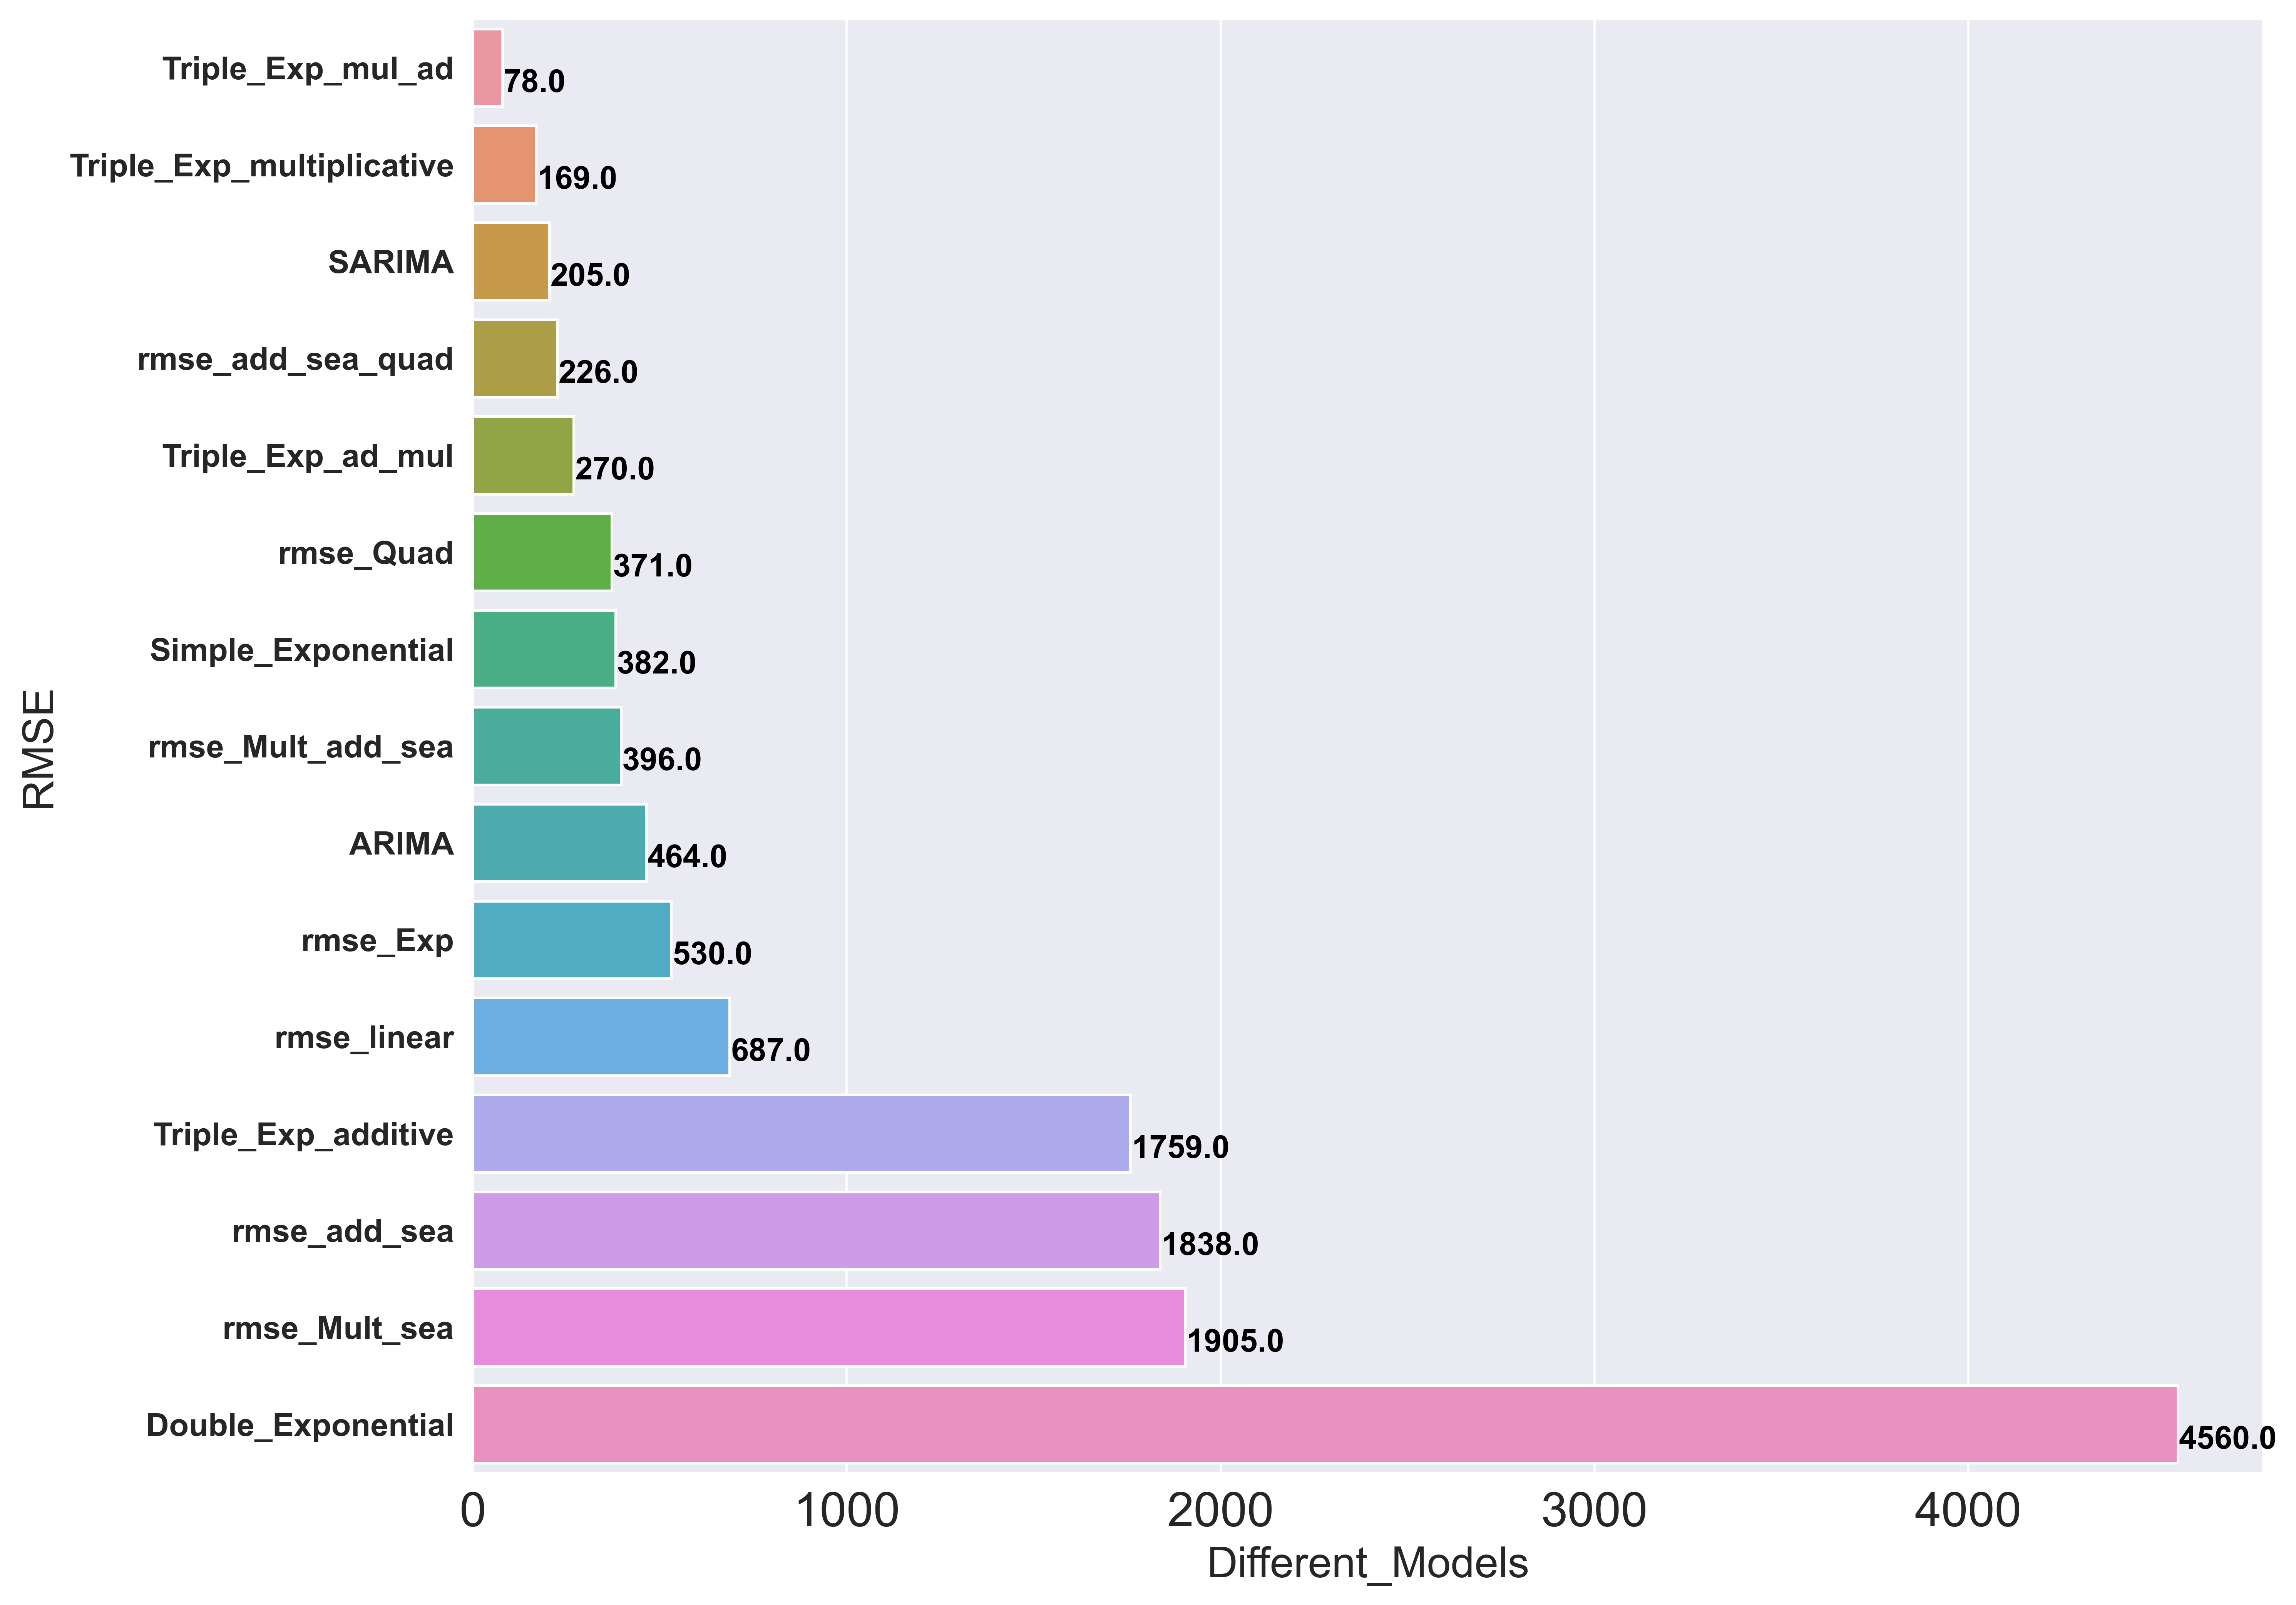

In [282]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()


# Conclusion:
    
With the lowest RMSE & lowest MAPE model is Triple Exponentila Addictive and multiplicative.

This Model gives the lowest RMSE score that is "78.38" & MAPE Score of 2.63.